# 🛒 Task 7 — Sales Forecasting (Walmart Dataset style)



# EDA (Exploratory Data Analysis), Insight & Visualization

### **A. Import Library & Dataset**

In [1]:
!pip install pandas
!pip install openpyxl
!pip install arch
!pip install pmdarima

import numpy as np
import pandas as panda
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sea

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


from arch import arch_model
from arch.univariate import ARX, GARCH, StudentsT, Normal

import warnings
warnings.filterwarnings("ignore")

In [2]:
Train_Walmart = panda.read_csv('train - Walmart Sales Forecast.csv')
Test_Walmart = panda.read_csv('test - Walmart Sales Forecast.csv')
Stores_Walmart = panda.read_csv('stores - Walmart Sales Forecast.csv')
Features_Walmart = panda.read_csv('features - Walmart Sales Forecast.csv')

### **B. Dataset Exploration**

### **1. Test Data**

In [3]:
Test_Walmart.head(5)

Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False

In [4]:
Test_Walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [5]:
# check missing values

Test_Walmart.isna().sum()    

Store        0
Dept         0
Date         0
IsHoliday    0
dtype: int64

In [6]:
# Check for duplicate data

Test_Walmart.duplicated().sum() 

0

In [12]:
# Filtering the data to view rows where 'IsHoliday' = True
holiday = Test_Walmart[Test_Walmart['IsHoliday'] == True]
print(holiday)

        Store  Dept        Date  IsHoliday
3           1     1  2012-11-23       True
8           1     1  2012-12-28       True
14          1     1  2013-02-08       True
42          1     2  2012-11-23       True
47          1     2  2012-12-28       True
...       ...   ...         ...        ...
114994     45    97  2012-12-28       True
115000     45    97  2013-02-08       True
115028     45    98  2012-11-23       True
115033     45    98  2012-12-28       True
115039     45    98  2013-02-08       True

[8928 rows x 4 columns]


In [15]:
panda.concat([Test_Walmart['Date'].head(5), Test_Walmart['Date'].tail(5)])

0         2012-11-02
1         2012-11-09
2         2012-11-16
3         2012-11-23
4         2012-11-30
115059    2013-06-28
115060    2013-07-05
115061    2013-07-12
115062    2013-07-19
115063    2013-07-26
Name: Date, dtype: object

### **2. Train Data**

In [3]:
Train_Walmart.head(5)

Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

In [4]:
Train_Walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [5]:
# check missing values

Train_Walmart.isna().sum()              

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [6]:
# Check for duplicate data

Train_Walmart.duplicated().sum()       

0

In [16]:
# Filtering the data to view rows where 'IsHoliday' = True
holiday = Train_Walmart[Train_Walmart['IsHoliday'] == True]
print(holiday)

        Store  Dept        Date  Weekly_Sales  IsHoliday
1           1     1  2010-02-12      46039.49       True
31          1     1  2010-09-10      18194.74       True
42          1     1  2010-11-26      18820.29       True
47          1     1  2010-12-31      19124.58       True
53          1     1  2011-02-11      37887.17       True
...       ...   ...         ...           ...        ...
421510     45    98  2011-09-09       1092.66       True
421521     45    98  2011-11-25        794.62       True
421526     45    98  2011-12-30        553.21       True
421532     45    98  2012-02-10        770.86       True
421562     45    98  2012-09-07        352.44       True

[29661 rows x 5 columns]


In [17]:
panda.concat([Train_Walmart['Date'].head(5), Train_Walmart['Date'].tail(5)])

0         2010-02-05
1         2010-02-12
2         2010-02-19
3         2010-02-26
4         2010-03-05
421565    2012-09-28
421566    2012-10-05
421567    2012-10-12
421568    2012-10-19
421569    2012-10-26
Name: Date, dtype: object

* **Descriptive Statistics**

Train_numerical & Train_categorical are made for observed the statistical information of Train_Walmart dataset

In [7]:
Train_numerical = Train_Walmart[['Store', 'Dept', 'Weekly_Sales']]
Train_categorical = Train_Walmart[['IsHoliday']]

In [8]:
Train_numerical.describe()

Store           Dept   Weekly_Sales
count  421570.000000  421570.000000  421570.000000
mean       22.200546      44.260317   15981.258123
std        12.785297      30.492054   22711.183519
min         1.000000       1.000000   -4988.940000
25%        11.000000      18.000000    2079.650000
50%        22.000000      37.000000    7612.030000
75%        33.000000      74.000000   20205.852500
max        45.000000      99.000000  693099.360000

In [9]:
Train_categorical.describe()

IsHoliday
count     421570
unique         2
top        False
freq      391909

In [10]:
# Modus/Mode
Weekly_Sales = Train_Walmart['Weekly_Sales']
Weekly_Sales.mode()[0]
print (f"Weekly_Sales :{Weekly_Sales.mode()[0]}")

# Q1
# The data at the 25th percentile
print ('Q1 :', Weekly_Sales.quantile(0.25))

# Q2
# The data at the 50th percentile
print ('Q2 :', Weekly_Sales.quantile(0.5))

# Q3
# The data at the 75th percentile
print ('Q3 :', Weekly_Sales.quantile(0.75))

# Q4
# The data at the 100th percentile
print ('Q4 :', Weekly_Sales.quantile(1))

# Range
# Range of values from maximum to minimum
print('Range:', Weekly_Sales.max()-Weekly_Sales.min())

# Variance
print ('Variance :', Weekly_Sales.var())

# Standart Deviation
print ('Standar Deviasi :', Weekly_Sales.std())

# Interquartile range is the distance from Q3 to Q1.
# It is useful for identifying outliers.
print('Inter Quartile Range (IQR):',Weekly_Sales.quantile(0.75)-Weekly_Sales.quantile(0.25))

Weekly_Sales :10.0
Q1 : 2079.6499999999996
Q2 : 7612.03
Q3 : 20205.8525
Q4 : 693099.36
Range: 698088.2999999999
Variance : 515797856.84110695
Standar Deviasi : 22711.18351916313
Inter Quartile Range (IQR): 18126.2025


* **Visualization**

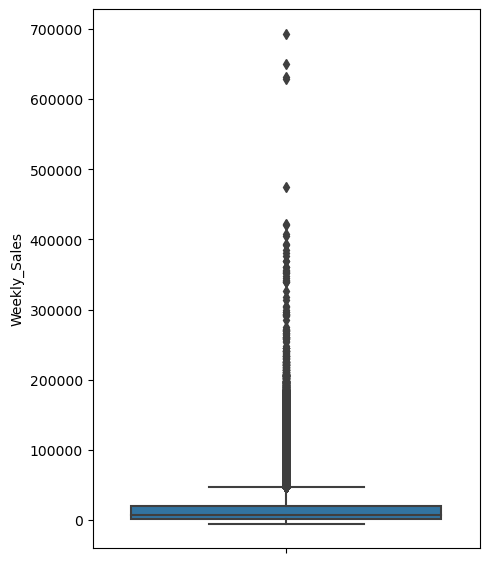

In [11]:
plt.figure(figsize = (5,7))
sea.boxplot(y='Weekly_Sales',data = Train_Walmart)
plt.show()

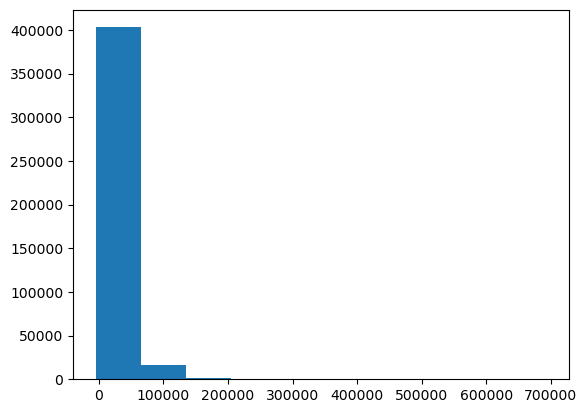

In [12]:
plt.hist(Train_Walmart['Weekly_Sales'])
plt.show()

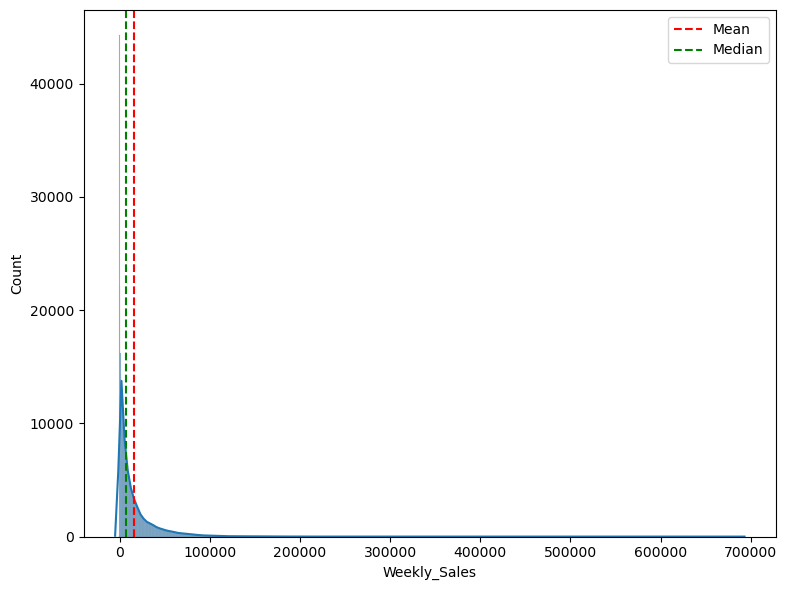

In [18]:
import matplotlib.pyplot as plt
import seaborn as sea

col = 'Weekly_Sales'

# Calculate mean, median, and mode values
mean_val = Train_Walmart[col].mean()
median_val = Train_Walmart[col].median()
mode_val = Train_Walmart[col].mode().iloc[0]

# Create Plot
fig, ax = plt.subplots(figsize=(8,6))
sea.histplot(data=Train_Walmart, x=col, ax=ax, kde=True)

# Add vertical lines for mean, median, and mode
ax.axvline(x=mean_val, color='r', linestyle='dashed', label='Mean')
ax.axvline(x=median_val, color='g', linestyle='dashed', label='Median')

# Showing Legenda
ax.legend()

# Showing Plot
plt.tight_layout()
plt.show()

**Conclusion :** <br>
**Train Dataset**

* Missing Values (-)
* Duplicate Values (-)
* Ouliers : Weekly_Sales column
* The mean and median of weekly sales show a significant difference. <br>
Mean = 15981 <br>
Median = 7612
* The distribution of weekly sales is positively skewed, as the median is less than the mean
 </br>



### **3. Stores Data**

In [13]:
Stores_Walmart.head(5)

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

In [14]:
Stores_Walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [15]:
Stores_Walmart.isna().sum()

Store    0
Type     0
Size     0
dtype: int64

In [16]:
Stores_Walmart.duplicated().sum()

0

* **Descriptive Statistics**

In [17]:
Stores_Walmart.describe()

Store           Size
count  45.000000      45.000000
mean   23.000000  130287.600000
std    13.133926   63825.271991
min     1.000000   34875.000000
25%    12.000000   70713.000000
50%    23.000000  126512.000000
75%    34.000000  202307.000000
max    45.000000  219622.000000

In [18]:
Stores_Walmart['Type'].value_counts()
print (f"Type :{Stores_Walmart['Type'].value_counts()}")

Type :Type
A    22
B    17
C     6
Name: count, dtype: int64


In [19]:
Stores_Walmart['Type'].describe()

count     45
unique     3
top        A
freq      22
Name: Type, dtype: object

In [20]:
Store = Stores_Walmart['Store']
Store.mode()[0]
print (f"Store :{Store.mode()[0]}")
       
Size = Stores_Walmart['Size']
Size.mode()[0]
print (f"Size :{Size.mode()[0]}")

Store :1
Size :39690


In [9]:
range_per_store = Stores_Walmart.groupby('Type')['Size'].agg(lambda x: x.max() - x.min())

print(range_per_store)

Type
A    179932
B    105292
C      3298
Name: Size, dtype: int64


In [10]:
# Calculating the maximum value for each store type
max_per_store = Stores_Walmart.groupby('Type')['Size'].max()
print("Maximum Value per Store Type:\n", max_per_store)

# Calculating the minimum value for each store type
min_per_store = Stores_Walmart.groupby('Type')['Size'].min()
print("\nMinimum Value per Store Type:\n", min_per_store)

Maximum Value per Store Type:
 Type
A    219622
B    140167
C     42988
Name: Size, dtype: int64

Minimum Value per Store Type:
 Type
A    39690
B    34875
C    39690
Name: Size, dtype: int64


**Conclusion :** <br>
**Stores Dataset**

* Missing Values (-)
* Duplicate Values (-)
* Ouliers (-)
* The mean and median of weekly sales show a significant difference <br>
Mean = 130287 <br>
Median = 126512
* All features (columns) have distinct values, with no mode, as each value is unique.


### **4. Features Data**

In [3]:
Features_Walmart.head(5)

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False

In [4]:
Features_Walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [5]:
Features_Walmart.duplicated().sum()

0

In [6]:
Features_Walmart.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [7]:
Features_numerical = ['Temperature','Fuel_Price','CPI','Unemployment']
Features_categorical = ['IsHoliday']

Features_numerical = Features_Walmart[['Temperature','Fuel_Price','CPI','Unemployment']]
Features_categorical = Features_Walmart[['IsHoliday']]

Features_numerical & Features_categorical are made for observed the statistical information of Features_Walmart dataset

* **Descriptive Statistics**

In [8]:
Features_numerical.describe()

Temperature   Fuel_Price          CPI  Unemployment
count  8190.000000  8190.000000  7605.000000   7605.000000
mean     59.356198     3.405992   172.460809      7.826821
std      18.678607     0.431337    39.738346      1.877259
min      -7.290000     2.472000   126.064000      3.684000
25%      45.902500     3.041000   132.364839      6.634000
50%      60.710000     3.513000   182.764003      7.806000
75%      73.880000     3.743000   213.932412      8.567000
max     101.950000     4.468000   228.976456     14.313000

In [9]:
Features_categorical.describe()

IsHoliday
count       8190
unique         2
top        False
freq        7605

In [10]:
Temperature = Features_Walmart['Temperature']
Temperature.mode()[0]
print (f"Temperature :{Temperature.mode()[0]}")
       
Fuel_Price = Features_Walmart['Fuel_Price']
Fuel_Price.mode()[0]
print (f"Fuel_Price :{Fuel_Price.mode()[0]}")

CPI = Features_Walmart['CPI']
CPI.mode()[0]
print (f"CPI :{CPI.mode()[0]}")

Unemployment = Features_Walmart['Unemployment']
Unemployment.mode()[0]
print (f"Unemployment :{Unemployment.mode()[0]}")

Temperature :50.43
Fuel_Price :3.417
CPI :132.7160968
Unemployment :8.099


* **Visualization**

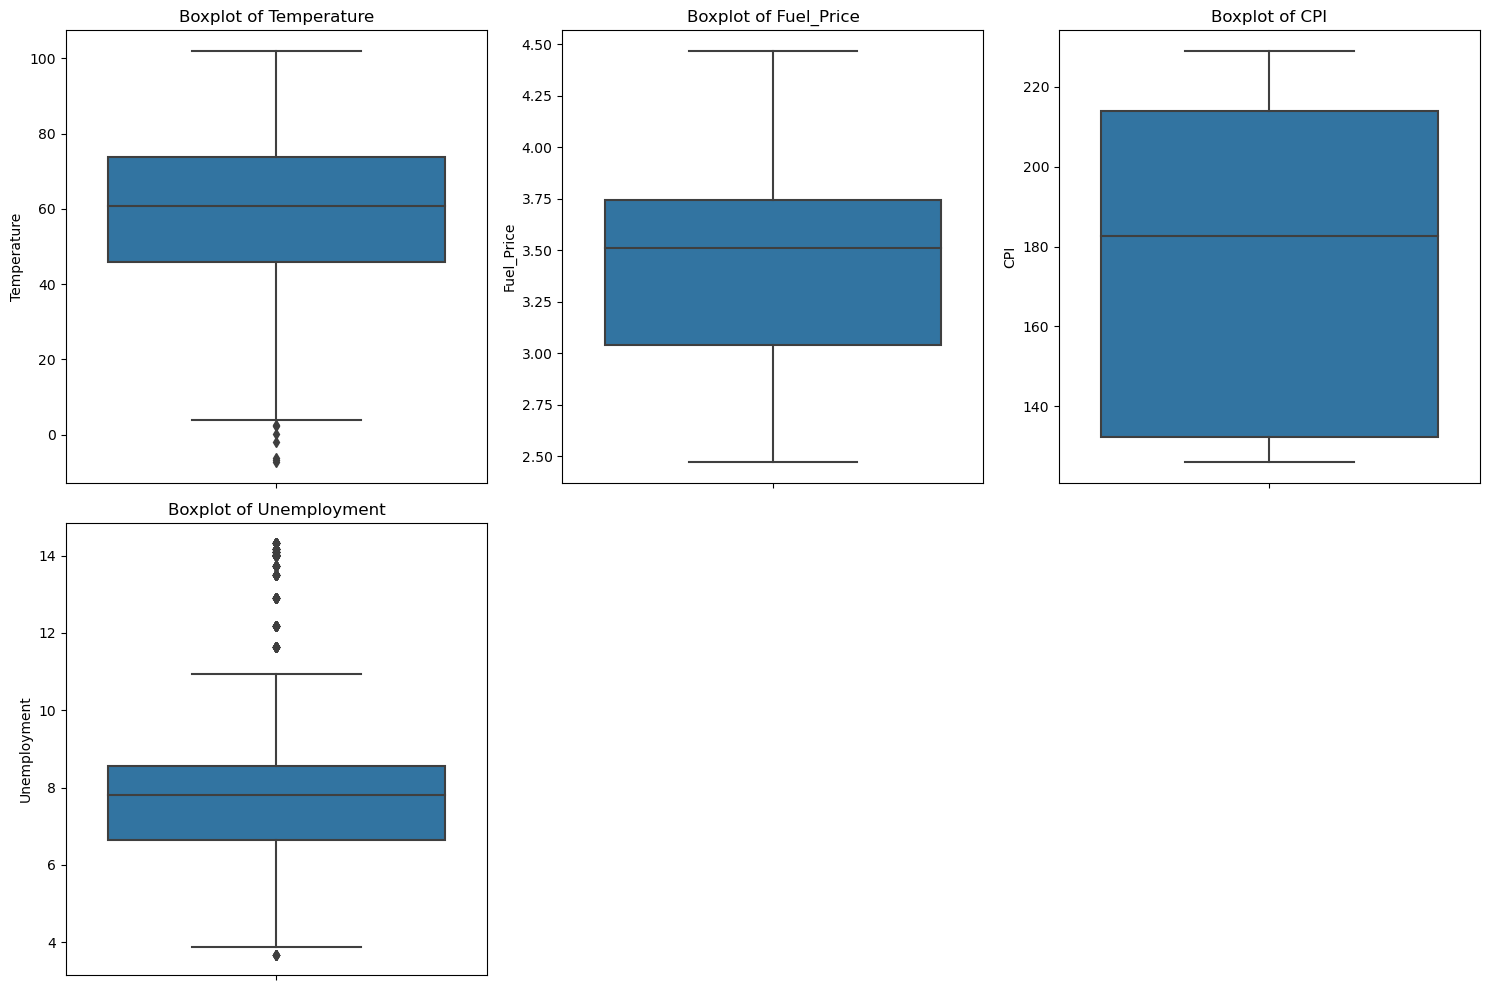

In [16]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(Features_numerical):
    plt.subplot(len(Features_numerical.columns)//3 + 1, 3, i + 1)  # Adjusting the grid
    sea.boxplot(data=Features_numerical, y=column)  # Creating a boxplot for the column
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

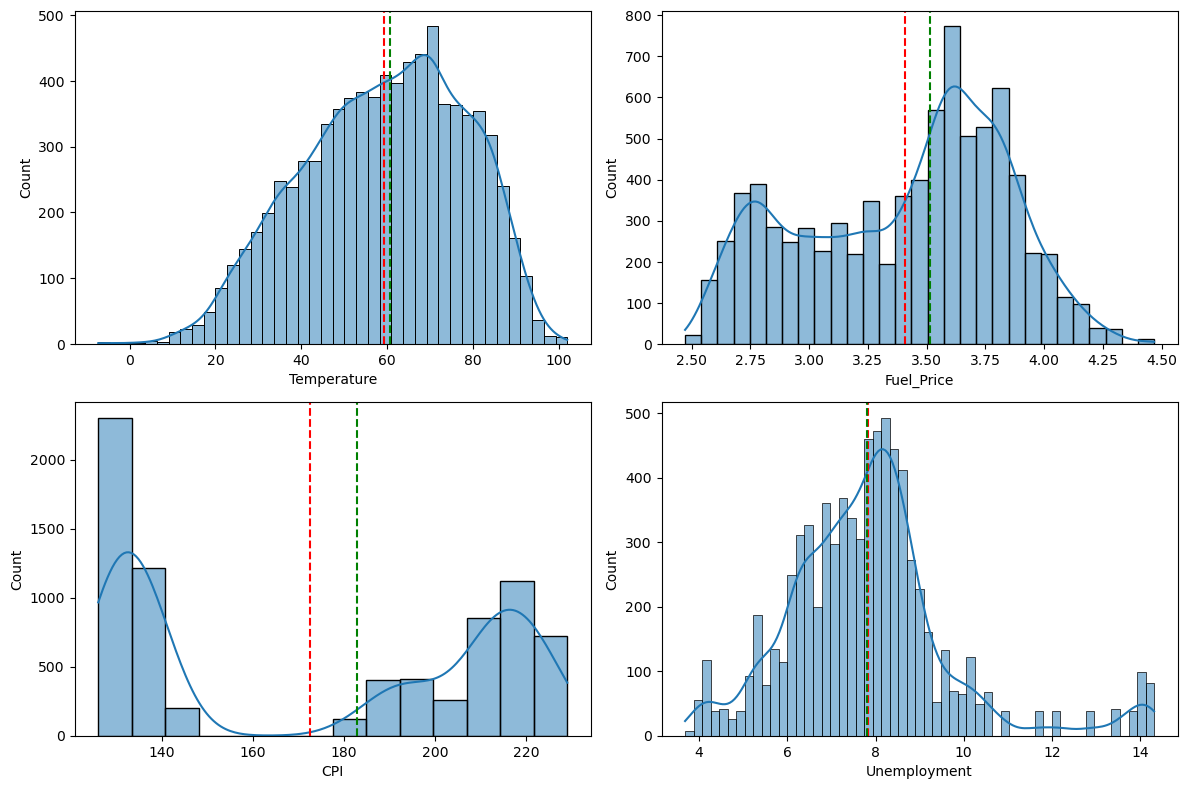

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
for i, col in enumerate(Features_numerical.columns):
  if col == 'Temperature' or col == 'CPI' or col == 'Unemployment'or col == 'Fuel_Price':


    # Calculate mean, median, and mode
    mean_val = Features_numerical[col].mean()
    median_val = Features_numerical[col].median()
    mode_val = Features_numerical[col].mode().iloc[0]

    # Correctly access the subplot using row and column indices
    row = i // 2  # Calculate row index
    col_index = i % 2  # Calculate column index
    ax = axes[row, col_index]  # Access the subplot using row and column indices

    sea.histplot(data=Features_numerical, x=col, ax=ax, kde=True)

    # Add vertical lines for mean, median, and mode
    ax.axvline(x=mean_val, color='r', linestyle='dashed', label='Mean')
    ax.axvline(x=median_val, color='g', linestyle='dashed', label='Median')


plt.tight_layout()
plt.show()

**Conclusion :** </br>
**Features Dataset**

* Missing Values : </br>
MarkDown1     4.158 </br>
MarkDown2     5.269 </br>
MarkDown3     4.577 </br>
MarkDown4     4.726 </br>
MarkDown5     4140 </br>
CPI           585 </br>
Unemployment  585 </br>
* Duplicate Values (-) </br>
* Ouliers : </br>
Unemployment & Temperature </br>

### **C. Merge Dataset**

In [3]:
df = Train_Walmart.merge(Features_Walmart, on=['Store', 'Date'], how='inner').merge(Stores_Walmart, on=['Store'], how='inner')
df.head(5)

Store  Dept        Date  Weekly_Sales  IsHoliday_x  Temperature  \
0      1     1  2010-02-05      24924.50        False        42.31   
1      1     2  2010-02-05      50605.27        False        42.31   
2      1     3  2010-02-05      13740.12        False        42.31   
3      1     4  2010-02-05      39954.04        False        42.31   
4      1     5  2010-02-05      32229.38        False        42.31   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        NaN        NaN        NaN        NaN        NaN   
1       2.572        NaN        NaN        NaN        NaN        NaN   
2       2.572        NaN        NaN        NaN        NaN        NaN   
3       2.572        NaN        NaN        NaN        NaN        NaN   
4       2.572        NaN        NaN        NaN        NaN        NaN   

          CPI  Unemployment  IsHoliday_y Type    Size  
0  211.096358         8.106        False    A  151315  
1  211.096358         8.106        False    A  151315  
2  211.096358         8.106        False    A  151315  
3  211.096358         8.106        False    A  151315  
4  211.096358         8.106        False    A  151315

In [4]:
df.shape

(421570, 17)

In [5]:
df.drop(['IsHoliday_y'], axis=1,inplace=True)

In [6]:
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)

In [7]:
df.head()

Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1  2010-02-05      24924.50      False        42.31       2.572   
1      1     2  2010-02-05      50605.27      False        42.31       2.572   
2      1     3  2010-02-05      13740.12      False        42.31       2.572   
3      1     4  2010-02-05      39954.04      False        42.31       2.572   
4      1     5  2010-02-05      32229.38      False        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.096358   
2        NaN        NaN        NaN        NaN        NaN  211.096358   
3        NaN        NaN        NaN        NaN        NaN  211.096358   
4        NaN        NaN        NaN        NaN        NaN  211.096358   

   Unemployment Type    Size  
0         8.106    A  151315  
1         8.106    A  151315  
2         8.106    A  151315  
3         8.106    A  151315  
4         8.106    A  151315

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [24]:
df.shape

(421570, 16)

In [18]:
# Checking for missing values in the dataset
def check_missing_values(df):
    missing_values = df.isnull().sum()
    if missing_values.any():
        print("Columns with missing values:")
        print(missing_values[missing_values > 0])
    else:
        print("There are no missing values in the dataset.")
check_missing_values(df)

Columns with missing values:
MarkDown1    270889
MarkDown2    310322
MarkDown3    284479
MarkDown4    286603
MarkDown5    270138
dtype: int64


In [20]:
df.describe().T

count           mean           std        min           25%  \
Store         421570.0      22.200546     12.785297      1.000     11.000000   
Dept          421570.0      44.260317     30.492054      1.000     18.000000   
Weekly_Sales  421570.0   15981.258123  22711.183519  -4988.940   2079.650000   
Temperature   421570.0      60.090059     18.447931     -2.060     46.680000   
Fuel_Price    421570.0       3.361027      0.458515      2.472      2.933000   
MarkDown1     150681.0    7246.420196   8291.221345      0.270   2240.270000   
MarkDown2     111248.0    3334.628621   9475.357325   -265.760     41.600000   
MarkDown3     137091.0    1439.421384   9623.078290    -29.100      5.080000   
MarkDown4     134967.0    3383.168256   6292.384031      0.220    504.220000   
MarkDown5     151432.0    4628.975079   5962.887455    135.160   1878.440000   
CPI           421570.0     171.201947     39.159276    126.064    132.022667   
Unemployment  421570.0       7.960289      1.863296      3.879      6.891000   
Size          421570.0  136727.915739  60980.583328  34875.000  93638.000000   

                       50%            75%            max  
Store             22.00000      33.000000      45.000000  
Dept              37.00000      74.000000      99.000000  
Weekly_Sales    7612.03000   20205.852500  693099.360000  
Temperature       62.09000      74.280000     100.140000  
Fuel_Price         3.45200       3.738000       4.468000  
MarkDown1       5347.45000    9210.900000   88646.760000  
MarkDown2        192.00000    1926.940000  104519.540000  
MarkDown3         24.60000     103.990000  141630.610000  
MarkDown4       1481.31000    3595.040000   67474.850000  
MarkDown5       3359.45000    5563.800000  108519.280000  
CPI              182.31878     212.416993     227.232807  
Unemployment       7.86600       8.572000      14.313000  
Size          140167.00000  202505.000000  219622.000000

**Dividing numerical and categorical features**

In [8]:
numeric=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_num = df.select_dtypes(include=numeric)
df_num.head(5)

Store  Dept  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1     1      24924.50        42.31       2.572        NaN        NaN   
1      1     2      50605.27        42.31       2.572        NaN        NaN   
2      1     3      13740.12        42.31       2.572        NaN        NaN   
3      1     4      39954.04        42.31       2.572        NaN        NaN   
4      1     5      32229.38        42.31       2.572        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment    Size  
0        NaN        NaN        NaN  211.096358         8.106  151315  
1        NaN        NaN        NaN  211.096358         8.106  151315  
2        NaN        NaN        NaN  211.096358         8.106  151315  
3        NaN        NaN        NaN  211.096358         8.106  151315  
4        NaN        NaN        NaN  211.096358         8.106  151315

In [9]:
df_cat = df.select_dtypes(include='object')
df_cat.head(5)

Date Type
0  2010-02-05    A
1  2010-02-05    A
2  2010-02-05    A
3  2010-02-05    A
4  2010-02-05    A

**Correlation Between Features and Targets**

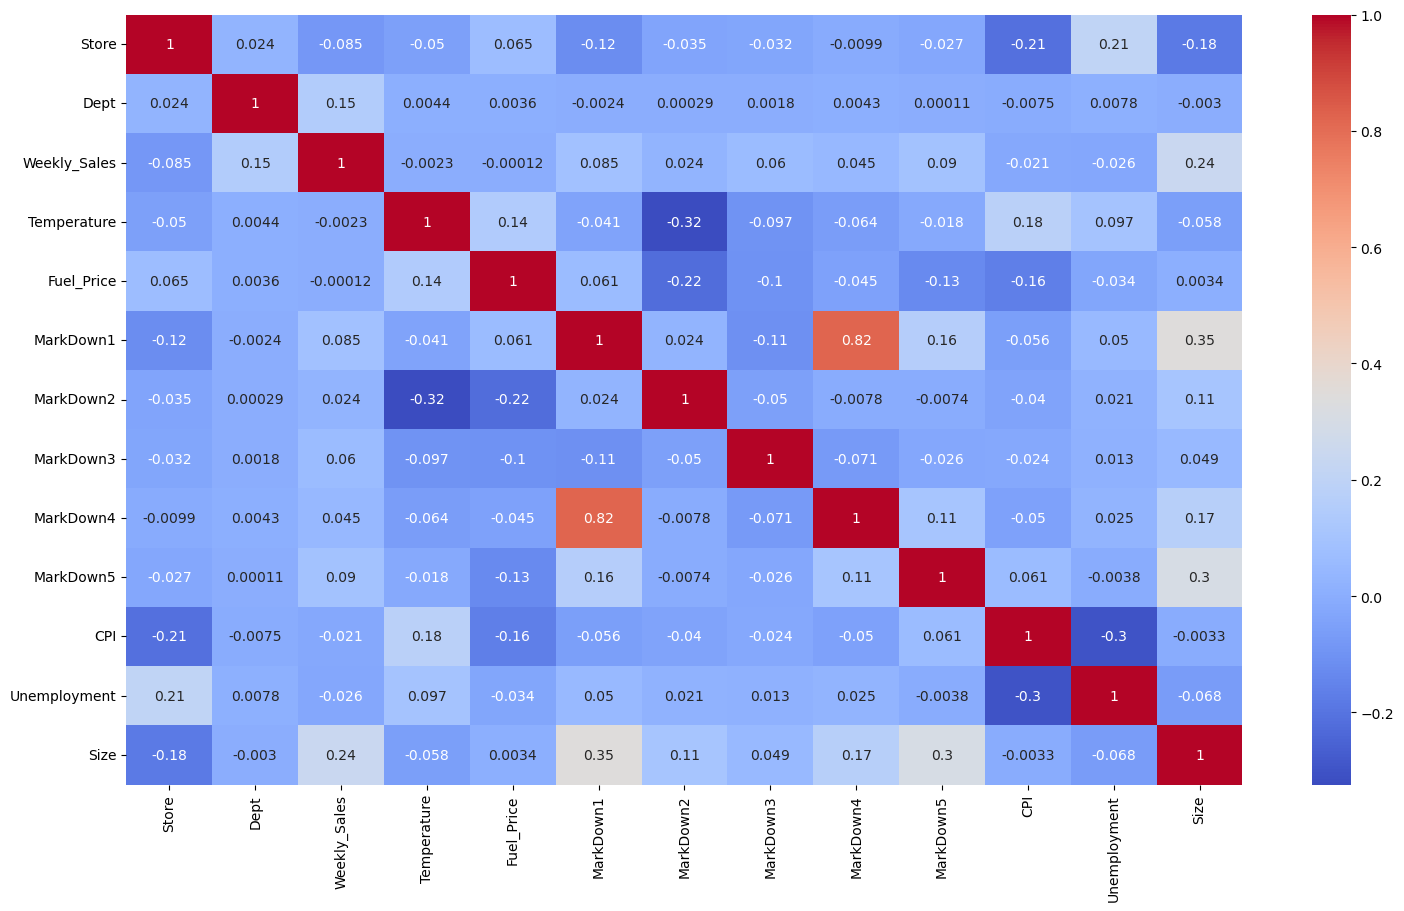

In [13]:
plt.figure(figsize=(18,10))
sea.heatmap(df_num.corr(), annot=True, cmap='coolwarm')
plt.show()

**Correlation Between Features and Targets**
* **Target :** Weekly_Sales
* **Features vs Target :**
    - Store : -0.085
    - Dept : 0.15
    - Is_Holiday : 0.013
    - Temperature : -0.023 
    - Fuel_Price : -0.00012
    - Markdown1 : 0.085
    - Markdown2 : 0.024
    - Markdown3 : 0.06
    - Markdown4 : 0.045
    - Markdown5 : 0.09
    - CPI : -0.021
    - Unemployment : -0.026
    - Size : 0.24

**Weekly Sales by Holiday - Raw Data**

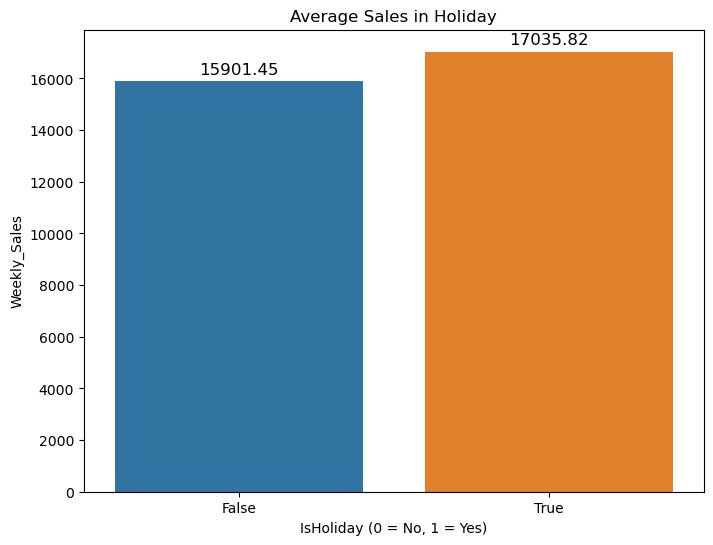

In [14]:
plt.figure(figsize=(8, 6))
ax = sea.barplot(x='IsHoliday', y='Weekly_Sales', data=df, ci=None)

for sales_holiday in ax.patches:
    ax.annotate(f'{sales_holiday.get_height():.2f}',  # format with 2 decimals
                (sales_holiday.get_x() + sales_holiday.get_width() / 2.,
                 sales_holiday.get_height()), 
                ha = 'center', va = 'baseline',
                fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.title('Average Sales in Holiday')
plt.xlabel('IsHoliday (0 = No, 1 = Yes)')
plt.ylabel('Weekly_Sales')
plt.show()

**Weekly Sales by Dept - Raw Data**

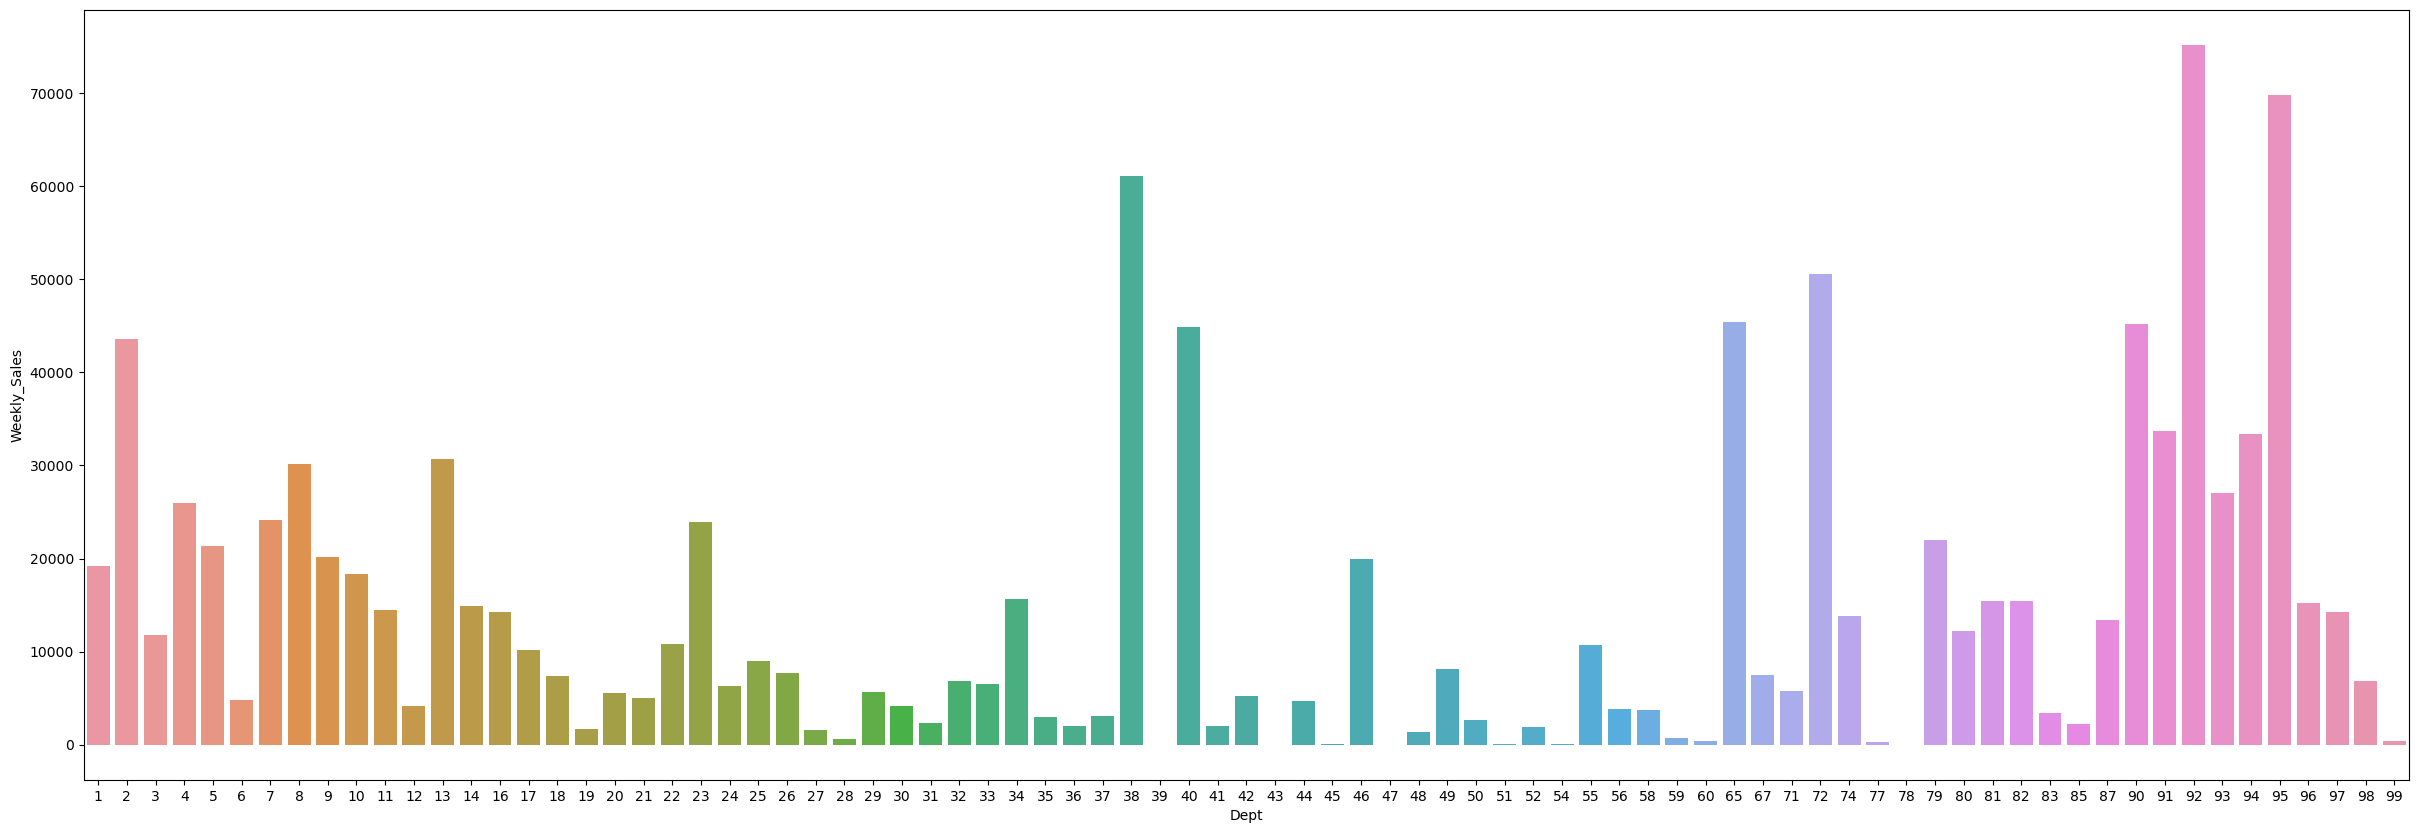

In [15]:
plt.figure(figsize=(30,10))
fig = sea.barplot(x='Dept', y='Weekly_Sales', data=df, ci=None)

**Weekly Sales by Store - Raw Data**

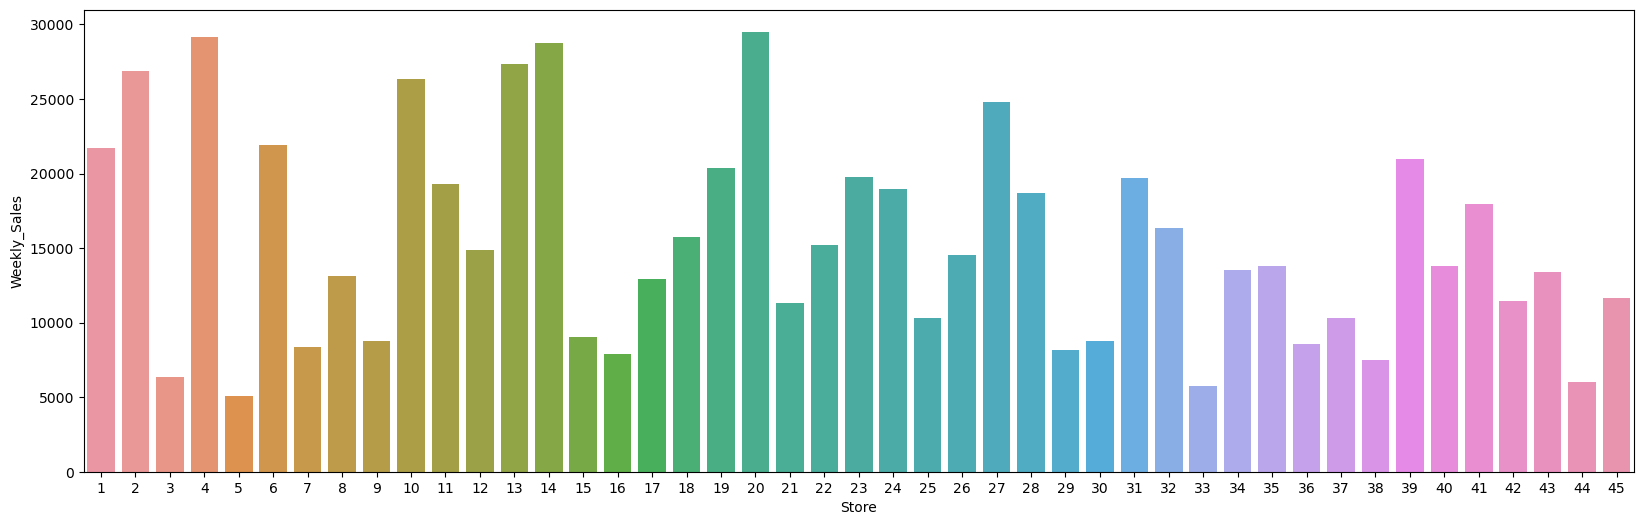

In [15]:
plt.figure(figsize=(20,6))
fig = sea.barplot(x='Store', y='Weekly_Sales', data=df, ci=None)

### **Sales for Each Stores and Department**

In [27]:
panda.options.display.max_columns=100 # to see columns 

Sales_each_store = panda.pivot_table(df, index='Store',
                                    columns='Dept',
                                    values='Weekly_Sales',
                                    aggfunc=np.mean)
display(Sales_each_store)

Dept             1              2             3             4             5   \
Store                                                                          
1      22513.322937   46102.090420  13150.478042  36964.154476  24257.941119   
2      30777.980769   65912.922517  17476.563357  45607.666573  30555.315315   
3       7328.621049   16841.775664   5509.300769   8434.186503  11695.366573   
4      36979.940070   93639.315385  19012.491678  56603.400140  45668.406783   
5       9774.553077   12317.953287   4101.085175   9860.806783   6699.202238   
6      23867.553776   50269.437273  16806.638811  34187.366503  34465.307622   
7       9542.801259   22603.690769   8633.536923  14950.518601  13860.350490   
8      14789.827343   35729.821748  10683.305105  21089.309301  19838.849231   
9      11846.558252   24969.477413   7497.356783  17165.947762  19282.746014   
10     39925.138951  109795.291469  32086.181469  48579.826364  58373.460280   
11     18860.911958   57114.326224  17628.778671  28837.744545  36663.363916   
12     17330.087622   74494.846224  17535.251678  26673.788182  27756.204615   
13     47020.455455   76339.960000  26116.623706  42563.275455  56786.934755   
14     30611.783357   77704.857972  19418.273986  52936.323287  33468.325035   
15     13845.747832   26317.410769  10470.811958  13082.172448  16465.706993   
16     11352.479371   23549.144965   7635.427273  14748.078112  13494.538671   
17     22801.609161   42231.844406  19278.955035  23961.357273  27082.325594   
18     21988.356224   63665.139510  16392.980490  26775.207203  22933.954965   
19     21504.029161   50841.072937  18414.224476  31365.545315  28759.223846   
20     40545.473217   78251.249930  15490.971259  51456.376643  41647.786503   
21     14950.049231   47780.599161  14607.126923  19354.728042  16090.874545   
22     21493.271119   53361.851888  13150.979510  32104.132378  23187.335105   
23     33186.460559   70522.580140  19912.564755  27324.303077  36895.869021   
24     18859.023357   40797.169301  11825.589021  29245.357552  29178.058811   
25     20145.897483   36871.310559  11788.130979  20351.455455  12422.996434   
26     19402.762937   27398.030979   7357.400769  24498.113846  17589.532587   
27     30437.976224   79001.049161  20226.734615  43596.933916  28059.038252   
28     20180.453986   57751.274336  12562.223287  27980.817203  28221.618392   
29     15504.699580   25181.662727   7995.955804  14326.216224  12931.821259   
30      9788.376643   12974.464476    739.981888  13216.100909    405.565944   
31     17356.652448   58512.131538  10616.675944  34848.899231  18715.630769   
32     22852.639510   50323.497343  15472.540140  28137.154965  20748.371888   
33      2379.086573    7471.425105    283.950140   6107.616014    112.728310   
34     19947.573077   34916.225874   8377.376434  19791.509021  21633.900559   
35     17082.647902   45578.456224  14308.382797  19495.631119  24858.433706   
36      2239.227413   13416.025664    381.324266   9873.505105    314.753982   
37     11024.235874   16511.446224   1297.862028  17614.013636   1137.631189   
38      6923.538531   10986.172657    498.700210  10669.501329    397.418322   
39     21925.021189   67338.429371  20569.701608  44807.515105  24043.436783   
40     18794.578811   26702.705175   6489.030350  24386.750559  17689.671678   
41     23205.259930   48349.828951  17021.833357  30538.574895  25513.943776   
42     10375.148392   15976.902448    814.451189  14885.264755   1052.296783   
43      7549.109021   20722.851469    999.648881  18227.382168    575.417326   
44      8049.992308    9377.273007    571.016713   7403.959580    960.670490   
45     17745.916014   35800.912448   9508.014965  24229.873147  16107.063077   

Dept             6             7             8             9             10  \
Store                                                                         
1       4801.780140  24566.487413  35718.257622  28062.052238  31033.386364   
2 

* Store numbers begin from 1 to 45, department numbers are from 1 to 99, but some numbers are missing such as there is no 88 or 89 etc. Meanwhile, total number of departments is 81. 
* From the pivot table, there are some wrong values such as there are 0 and minus values for weekly sales. But sales amount can not be minus. Also, it is impossible for one department not to sell anything whole week.

## Data Pre-Processing

### **A. Handling Missing Values**

**Replace NaN values with 0**

In [28]:
# Checking for missing values in the dataset
def check_missing_values(df):
    missing_values = df.isnull().sum()
    if missing_values.any():
        print("Columns with missing values:")
        print(missing_values[missing_values > 0])
    else:
        print("There are no missing values in the dataset.")
check_missing_values(df)

Columns with missing values:
MarkDown1    270889
MarkDown2    310322
MarkDown3    284479
MarkDown4    286603
MarkDown5    270138
dtype: int64


In [10]:
df = df.fillna(0)

In [36]:
df.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

In [40]:
print(df.isna().sum())
print(df[df.isna().any(axis=1)])

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64
Empty DataFrame
Columns: [Store, Dept, Date, Weekly_Sales, IsHoliday, Temperature, Fuel_Price, MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5, CPI, Unemployment, Type, Size]
Index: []


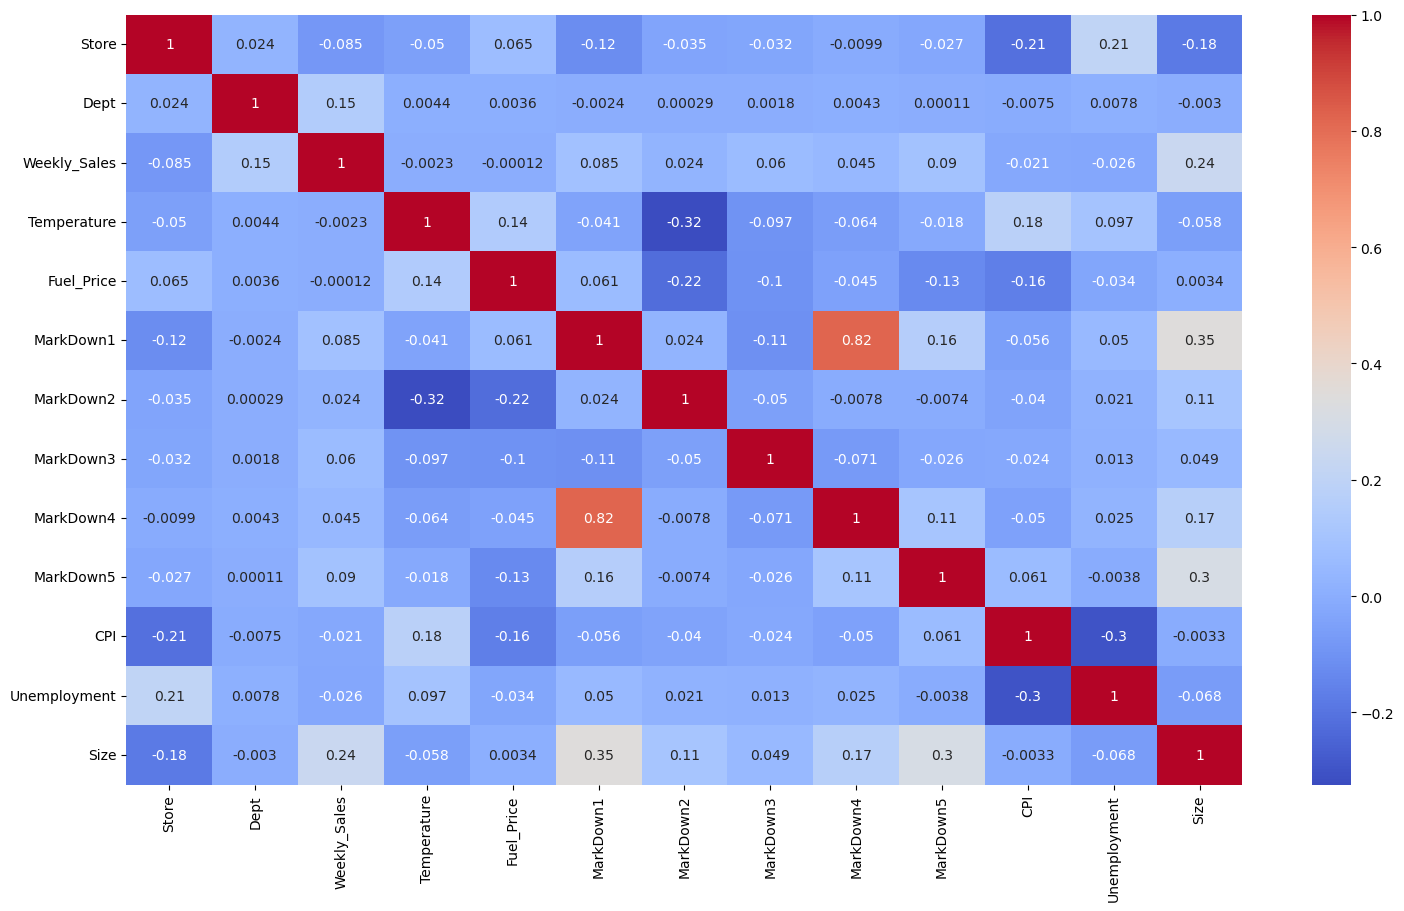

In [20]:
plt.figure(figsize=(18,10))
sea.heatmap(df_num.corr(), annot=True, cmap='coolwarm')
plt.show()

**Correlation Between Features and Targets**
* **Target :** Weekly_Sales
* **Features vs Target :**
    - Store : -0.085
    - Dept : 0.15
    - Is_Holiday : 0.013
    - Temperature : -0.023 
    - Fuel_Price : -0.00012
    - Markdown1 : 0.085
    - Markdown2 : 0.024
    - Markdown3 : 0.06
    - Markdown4 : 0.045
    - Markdown5 : 0.09
    - CPI : -0.021
    - Unemployment : -0.026
    - Size : 0.24

In [27]:
df.describe().T

count           mean           std        min           25%  \
Store         421570.0      22.200546     12.785297      1.000     11.000000   
Dept          421570.0      44.260317     30.492054      1.000     18.000000   
Weekly_Sales  421570.0   15981.258123  22711.183519  -4988.940   2079.650000   
Temperature   421570.0      60.090059     18.447931     -2.060     46.680000   
Fuel_Price    421570.0       3.361027      0.458515      2.472      2.933000   
MarkDown1     421570.0    2590.074819   6052.385934      0.000      0.000000   
MarkDown2     421570.0     879.974298   5084.538801   -265.760      0.000000   
MarkDown3     421570.0     468.087665   5528.873453    -29.100      0.000000   
MarkDown4     421570.0    1083.132268   3894.529945      0.000      0.000000   
MarkDown5     421570.0    1662.772385   4207.629321      0.000      0.000000   
CPI           421570.0     171.201947     39.159276    126.064    132.022667   
Unemployment  421570.0       7.960289      1.863296      3.879      6.891000   
Size          421570.0  136727.915739  60980.583328  34875.000  93638.000000   

                       50%            75%            max  
Store             22.00000      33.000000      45.000000  
Dept              37.00000      74.000000      99.000000  
Weekly_Sales    7612.03000   20205.852500  693099.360000  
Temperature       62.09000      74.280000     100.140000  
Fuel_Price         3.45200       3.738000       4.468000  
MarkDown1          0.00000    2809.050000   88646.760000  
MarkDown2          0.00000       2.200000  104519.540000  
MarkDown3          0.00000       4.540000  141630.610000  
MarkDown4          0.00000     425.290000   67474.850000  
MarkDown5          0.00000    2168.040000  108519.280000  
CPI              182.31878     212.416993     227.232807  
Unemployment       7.86600       8.572000      14.313000  
Size          140167.00000  202505.000000  219622.000000

**Conclusion :** <br>
There is no significant difference between handling missing values or not, except for the Markdown 1-5 columns, where missing values are present only in those columns.

### **B. Filtering Data**

In [11]:
df.loc[df['Weekly_Sales']<=0]

Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  \
188         1    47  2010-02-19       -863.00      False        39.93   
406         1    47  2010-03-12       -698.00      False        57.79   
2549        1    47  2010-10-08        -58.00      False        63.93   
3632        1    54  2011-01-21        -50.00      False        44.04   
4132        1    47  2011-03-11          0.00      False        53.56   
...       ...   ...         ...           ...        ...          ...   
420066     45    49  2012-05-25         -4.97      False        67.21   
420403     45    49  2012-06-29        -34.00      False        75.22   
420736     45    49  2012-08-03         -1.91      False        76.58   
421007     45    54  2012-08-31          0.00      False        75.09   
421142     45    49  2012-09-14         -6.83      False        67.87   

        Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
188          2.514       0.00       0.00       0.00       0.00       0.00   
406          2.667       0.00       0.00       0.00       0.00       0.00   
2549         2.633       0.00       0.00       0.00       0.00       0.00   
3632         3.016       0.00       0.00       0.00       0.00       0.00   
4132         3.459       0.00       0.00       0.00       0.00       0.00   
...            ...        ...        ...        ...        ...        ...   
420066       3.798    5370.39       0.00     361.22    1287.62    2461.81   
420403       3.506    3291.36     425.60       0.00     314.88    2255.34   
420736       3.654   24853.05      39.56      17.96   11142.69    2768.32   
421007       3.867   23641.30       6.00      92.93    6988.31    3992.13   
421142       3.948   11407.95       0.00       4.30    3421.72    5268.92   

               CPI  Unemployment Type    Size  
188     211.289143         8.106    A  151315  
406     211.380643         8.106    A  151315  
2549    211.746754         7.838    A  151315  
3632    211.827234         7.742    A  151315  
4132    214.111056         7.742    A  151315  
...            ...           ...  ...     ...  
420066  191.002810         8.567    B  118221  
420403  191.099246         8.567    B  118221  
420736  191.164090         8.684    B  118221  
421007  191.461281         8.684    B  118221  
421142  191.699850         8.684    B  118221  

[1358 rows x 16 columns]

The analysis revealed that there are 1,358 rows out of a total of 421,570 rows with Weekly_Sales values below or equal to zero. Since this represents only 0.3% of the total dataset, these rows were removed to ensure the integrity and accuracy of the analysis and modeling.

In [12]:
df = df.loc[df['Weekly_Sales'] > 0]

In [13]:
panda.options.display.max_columns=100 # to see columns 

Sales_each_store = panda.pivot_table(df, index='Store',
                                    columns='Dept',
                                    values='Weekly_Sales',
                                    aggfunc=np.mean)
display(Sales_each_store)

Dept             1              2             3             4             5   \
Store                                                                          
1      22513.322937   46102.090420  13150.478042  36964.154476  24257.941119   
2      30777.980769   65912.922517  17476.563357  45607.666573  30555.315315   
3       7328.621049   16841.775664   5509.300769   8434.186503  11695.366573   
4      36979.940070   93639.315385  19012.491678  56603.400140  45668.406783   
5       9774.553077   12317.953287   4101.085175   9860.806783   6699.202238   
6      23867.553776   50269.437273  16806.638811  34187.366503  34465.307622   
7       9542.801259   22603.690769   8633.536923  14950.518601  13860.350490   
8      14789.827343   35729.821748  10683.305105  21089.309301  19838.849231   
9      11846.558252   24969.477413   7497.356783  17165.947762  19282.746014   
10     39925.138951  109795.291469  32086.181469  48579.826364  58373.460280   
11     18860.911958   57114.326224  17628.778671  28837.744545  36663.363916   
12     17330.087622   74494.846224  17535.251678  26673.788182  27756.204615   
13     47020.455455   76339.960000  26116.623706  42563.275455  56786.934755   
14     30611.783357   77704.857972  19418.273986  52936.323287  33468.325035   
15     13845.747832   26317.410769  10470.811958  13082.172448  16465.706993   
16     11352.479371   23549.144965   7635.427273  14748.078112  13494.538671   
17     22801.609161   42231.844406  19278.955035  23961.357273  27082.325594   
18     21988.356224   63665.139510  16392.980490  26775.207203  22933.954965   
19     21504.029161   50841.072937  18414.224476  31365.545315  28759.223846   
20     40545.473217   78251.249930  15490.971259  51456.376643  41647.786503   
21     14950.049231   47780.599161  14607.126923  19354.728042  16090.874545   
22     21493.271119   53361.851888  13150.979510  32104.132378  23187.335105   
23     33186.460559   70522.580140  19912.564755  27324.303077  36895.869021   
24     18859.023357   40797.169301  11825.589021  29245.357552  29178.058811   
25     20145.897483   36871.310559  11788.130979  20351.455455  12422.996434   
26     19402.762937   27398.030979   7357.400769  24498.113846  17589.532587   
27     30437.976224   79001.049161  20226.734615  43596.933916  28059.038252   
28     20180.453986   57751.274336  12562.223287  27980.817203  28221.618392   
29     15504.699580   25181.662727   7995.955804  14326.216224  12931.821259   
30      9788.376643   12974.464476    739.981888  13216.100909    408.422324   
31     17356.652448   58512.131538  10616.675944  34848.899231  18715.630769   
32     22852.639510   50323.497343  15472.540140  28137.154965  20748.371888   
33      2379.086573    7471.425105    283.950140   6107.616014    112.728310   
34     19947.573077   34916.225874   8377.376434  19791.509021  21633.900559   
35     17082.647902   45578.456224  14308.382797  19495.631119  24858.433706   
36      2239.227413   13416.025664    381.324266   9873.505105    314.753982   
37     11024.235874   16511.446224   1297.862028  17614.013636   1137.631189   
38      6923.538531   10986.172657    498.700210  10669.501329    397.418322   
39     21925.021189   67338.429371  20569.701608  44807.515105  24043.436783   
40     18794.578811   26702.705175   6489.030350  24386.750559  17689.671678   
41     23205.259930   48349.828951  17021.833357  30538.574895  25513.943776   
42     10375.148392   15976.902448    814.451189  14885.264755   1052.296783   
43      7549.109021   20722.851469    999.648881  18227.382168    575.417326   
44      8049.992308    9377.273007    571.016713   7403.959580    960.670490   
45     17745.916014   35800.912448   9508.014965  24229.873147  16107.063077   

Dept             6             7             8             9             10  \
Store                                                                         
1       4836.578944  24566.487413  35718.257622  28062.052238  31033.386364   
2 

### **C. Feature Engineering**

* **Create new features : Public Holiday and Regular Day**

In [30]:
public_holiday = df.loc[df['IsHoliday']==True]
public_holiday['Date'].unique() 

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [31]:
regular_day = df.loc[df['IsHoliday']==False]
regular_day['Date'].nunique() 

133

All holidays are not in the data. There are 4 holiday values such as; </br>

**Super Bowl:** 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13 </br>
**Labor Day:** 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13 </br>
**Thanksgiving:** 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13 </br>
**Christmas:** 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13 </br>
    
After the 07-Sep-2012 holidays are in test set for prediction. When we look at the data, average weekly sales for holidays are significantly higher than not-holiday days. In train data, there are 133 weeks for non-holiday and 10 weeks for holiday.

* **Create new features : Super Bowl, Labor Day, Thanksgiving and Christmas**

In [32]:
# Super bowl dates in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [33]:
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [34]:
# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [35]:
#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

* **Create new features : Week, Month and Year**

In [36]:
df["Date"] = panda.to_datetime(df["Date"])

In [37]:
df['week'] =df["Date"].dt.isocalendar().week
df['month'] =df['Date'].dt.month 
df['year'] =df['Date'].dt.year

### **D. Feature Encoding**

* **Change the type of 'IsHoliday' column from boolean to numerical**

In [38]:
df['IsHoliday'] = df['IsHoliday'].astype(int)
df['IsHoliday'] = panda.to_numeric(df['IsHoliday'], errors='coerce')

* **Convert the 'Date' column to datetime format**

In [39]:
df["Date"] = panda.to_datetime(df["Date"])

* **Convert the 'Type' column from categorical data to a numerical format**

In [40]:
df['Type'] = df['Type'].apply(lambda x: 1 if x == 'A' else 2 if x == 'B' else 3)

* **Changing Boolean to Numerical**

In [41]:
df['Super_Bowl'] = df['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1
df['Thanksgiving'] = df['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1
df['Labor_Day'] = df['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1
df['Christmas'] = df['Christmas'].astype(bool).astype(int) # changing T,F to 0-1
df['IsHoliday'] = df['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1

In [42]:
df.head(5)

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50          0        42.31       2.572   
1      1     2 2010-02-05      50605.27          0        42.31       2.572   
2      1     3 2010-02-05      13740.12          0        42.31       2.572   
3      1     4 2010-02-05      39954.04          0        42.31       2.572   
4      1     5 2010-02-05      32229.38          0        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        0.0        0.0        0.0        0.0        0.0  211.096358   
1        0.0        0.0        0.0        0.0        0.0  211.096358   
2        0.0        0.0        0.0        0.0        0.0  211.096358   
3        0.0        0.0        0.0        0.0        0.0  211.096358   
4        0.0        0.0        0.0        0.0        0.0  211.096358   

   Unemployment  Type    Size  Super_Bowl  Labor_Day  Thanksgiving  Christmas  \
0         8.106     1  151315           0          0             0          0   
1         8.106     1  151315           0          0             0          0   
2         8.106     1  151315           0          0             0          0   
3         8.106     1  151315           0          0             0          0   
4         8.106     1  151315           0          0             0          0   

   week  month  year  
0     5      2  2010  
1     5      2  2010  
2     5      2  2010  
3     5      2  2010  
4     5      2  2010

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420212 entries, 0 to 421569
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         420212 non-null  int64         
 1   Dept          420212 non-null  int64         
 2   Date          420212 non-null  datetime64[ns]
 3   Weekly_Sales  420212 non-null  float64       
 4   IsHoliday     420212 non-null  int32         
 5   Temperature   420212 non-null  float64       
 6   Fuel_Price    420212 non-null  float64       
 7   MarkDown1     420212 non-null  float64       
 8   MarkDown2     420212 non-null  float64       
 9   MarkDown3     420212 non-null  float64       
 10  MarkDown4     420212 non-null  float64       
 11  MarkDown5     420212 non-null  float64       
 12  CPI           420212 non-null  float64       
 13  Unemployment  420212 non-null  float64       
 14  Type          420212 non-null  int64         
 15  Size          420212 n

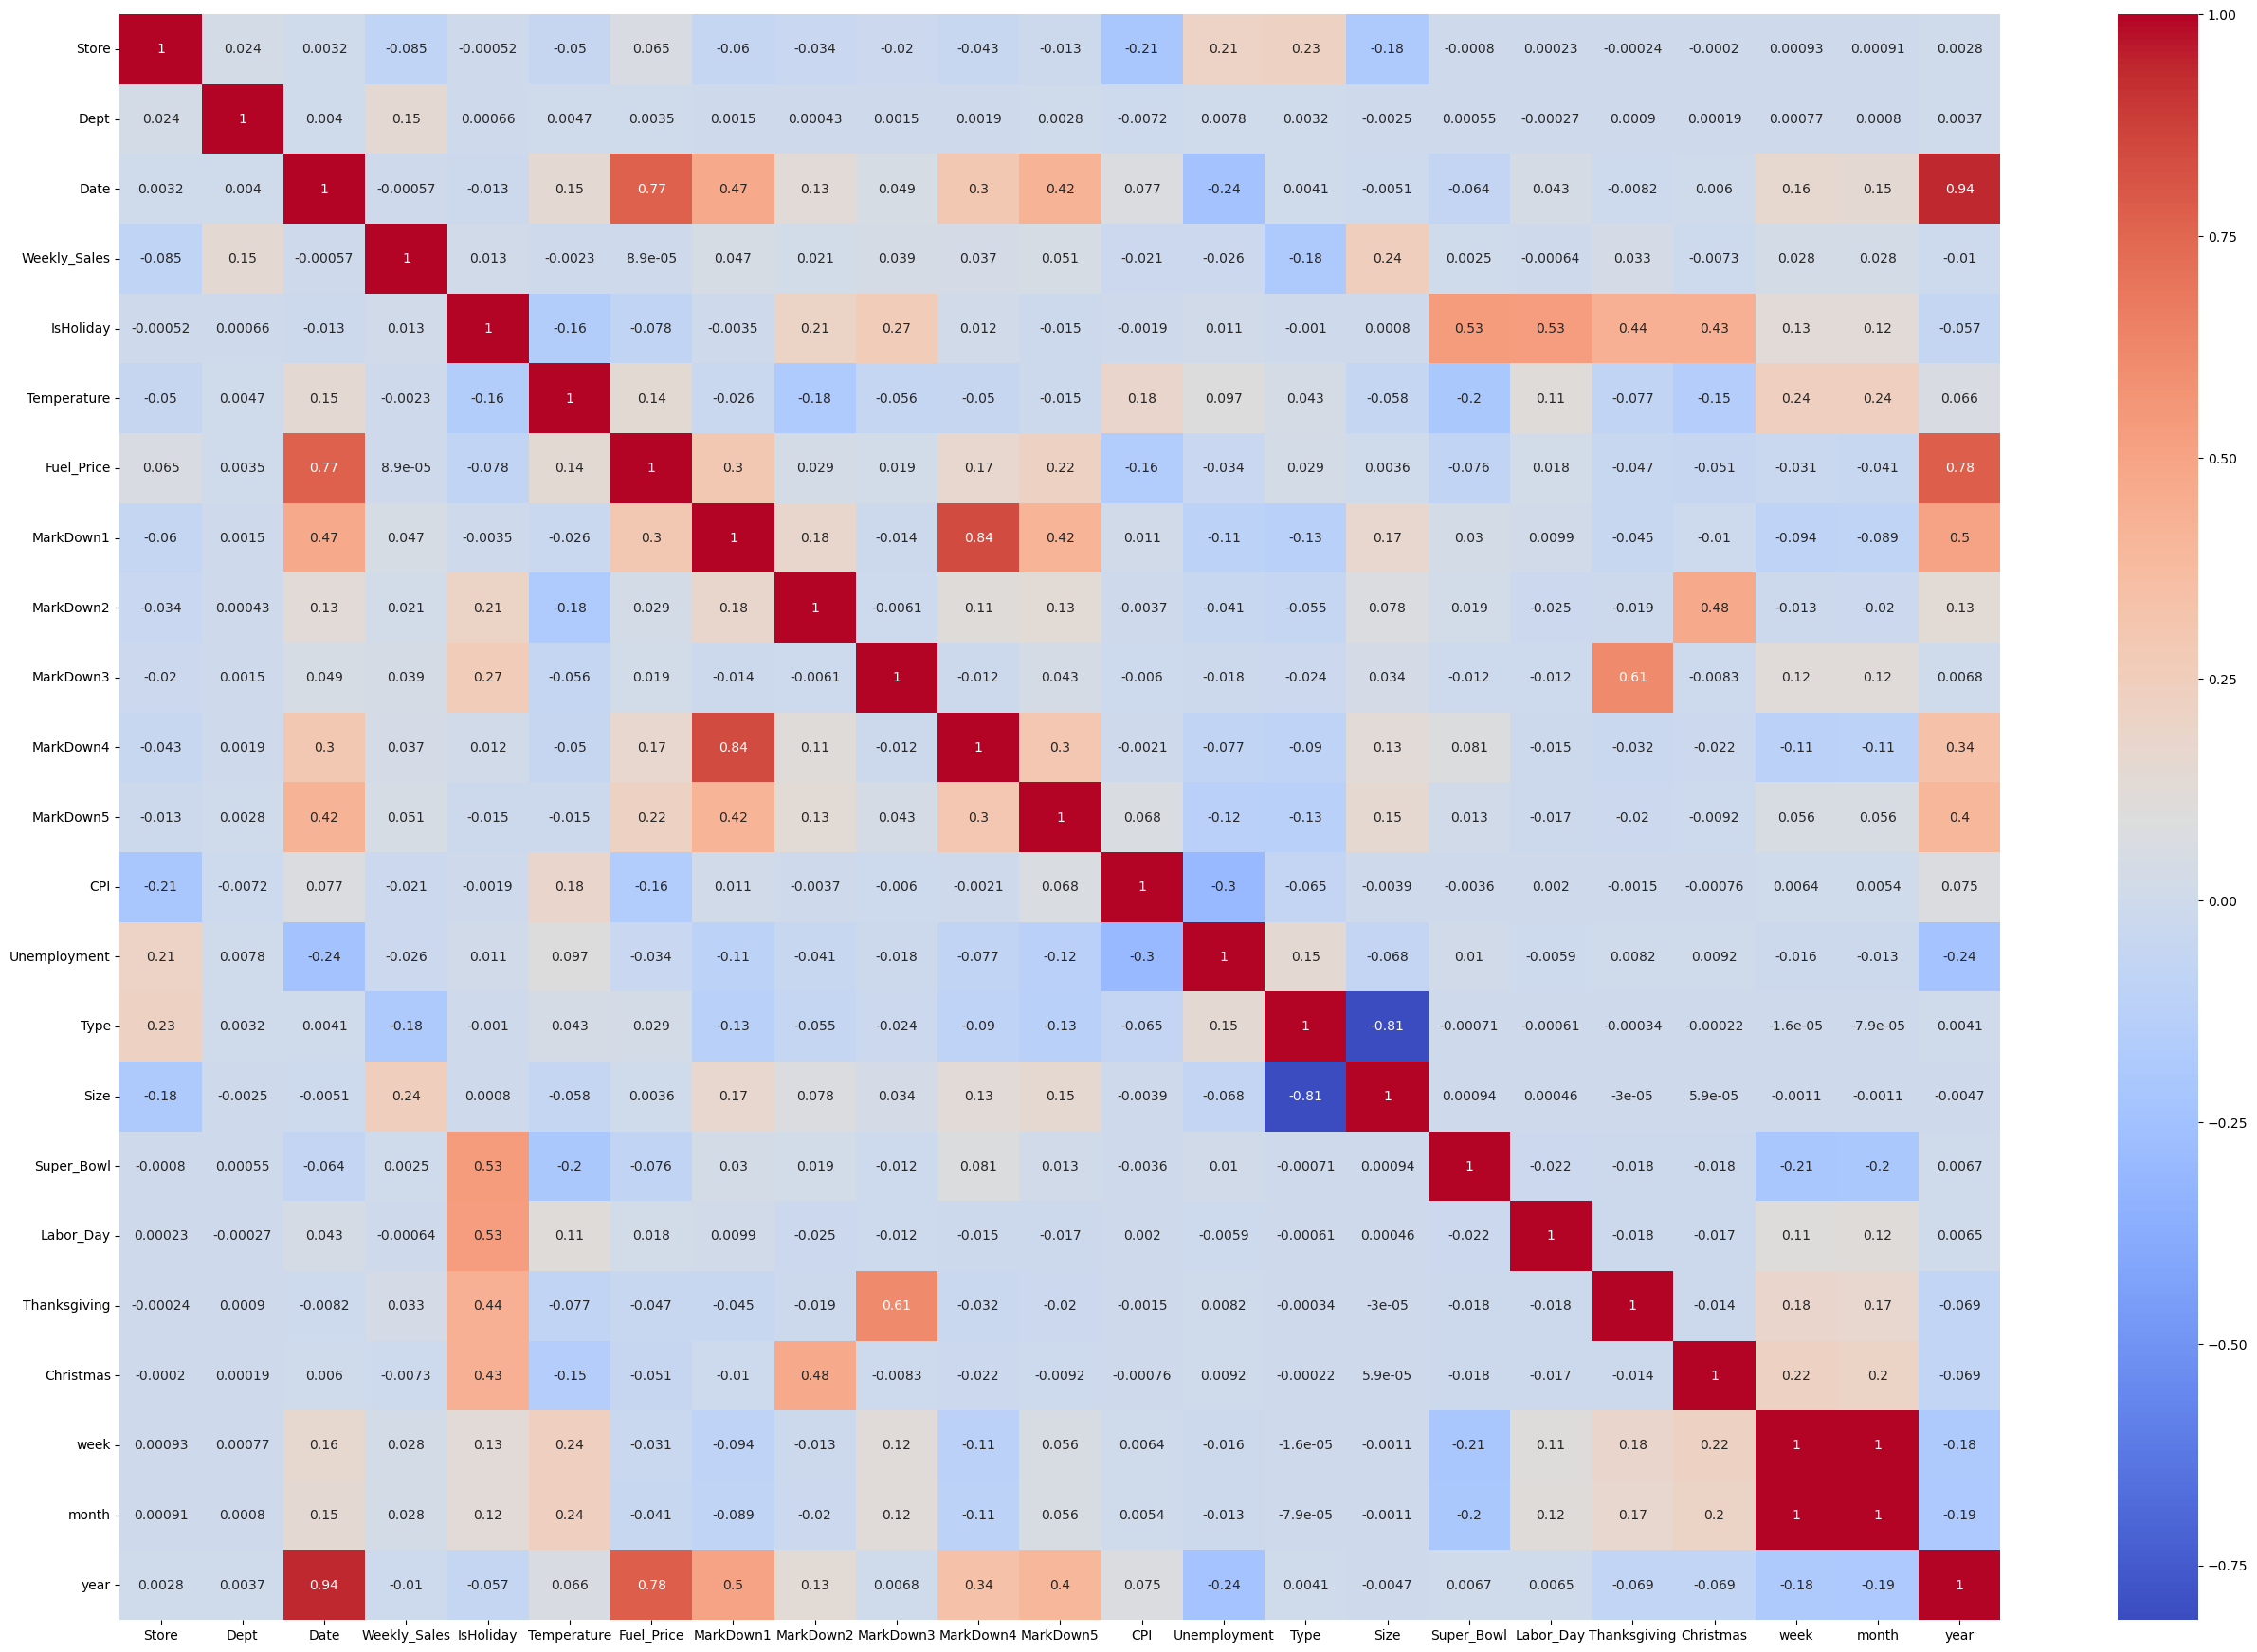

In [40]:
plt.figure(figsize=(32,22))
sea.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

* Temperature, Unemployment, CPI, and Fuel Price have no significant effect on weekly sales.
* Markdown 4 and 5 are highly correlated with Markdown 1, which could indicate multicollinearity.
* Month, week, and year are also highly correlated with each other, which could indicate multicollinearity.

## **Features Selection and Analysis of Each Feature After Pre-Processing**

### **1. Weekly Sales by Departement**

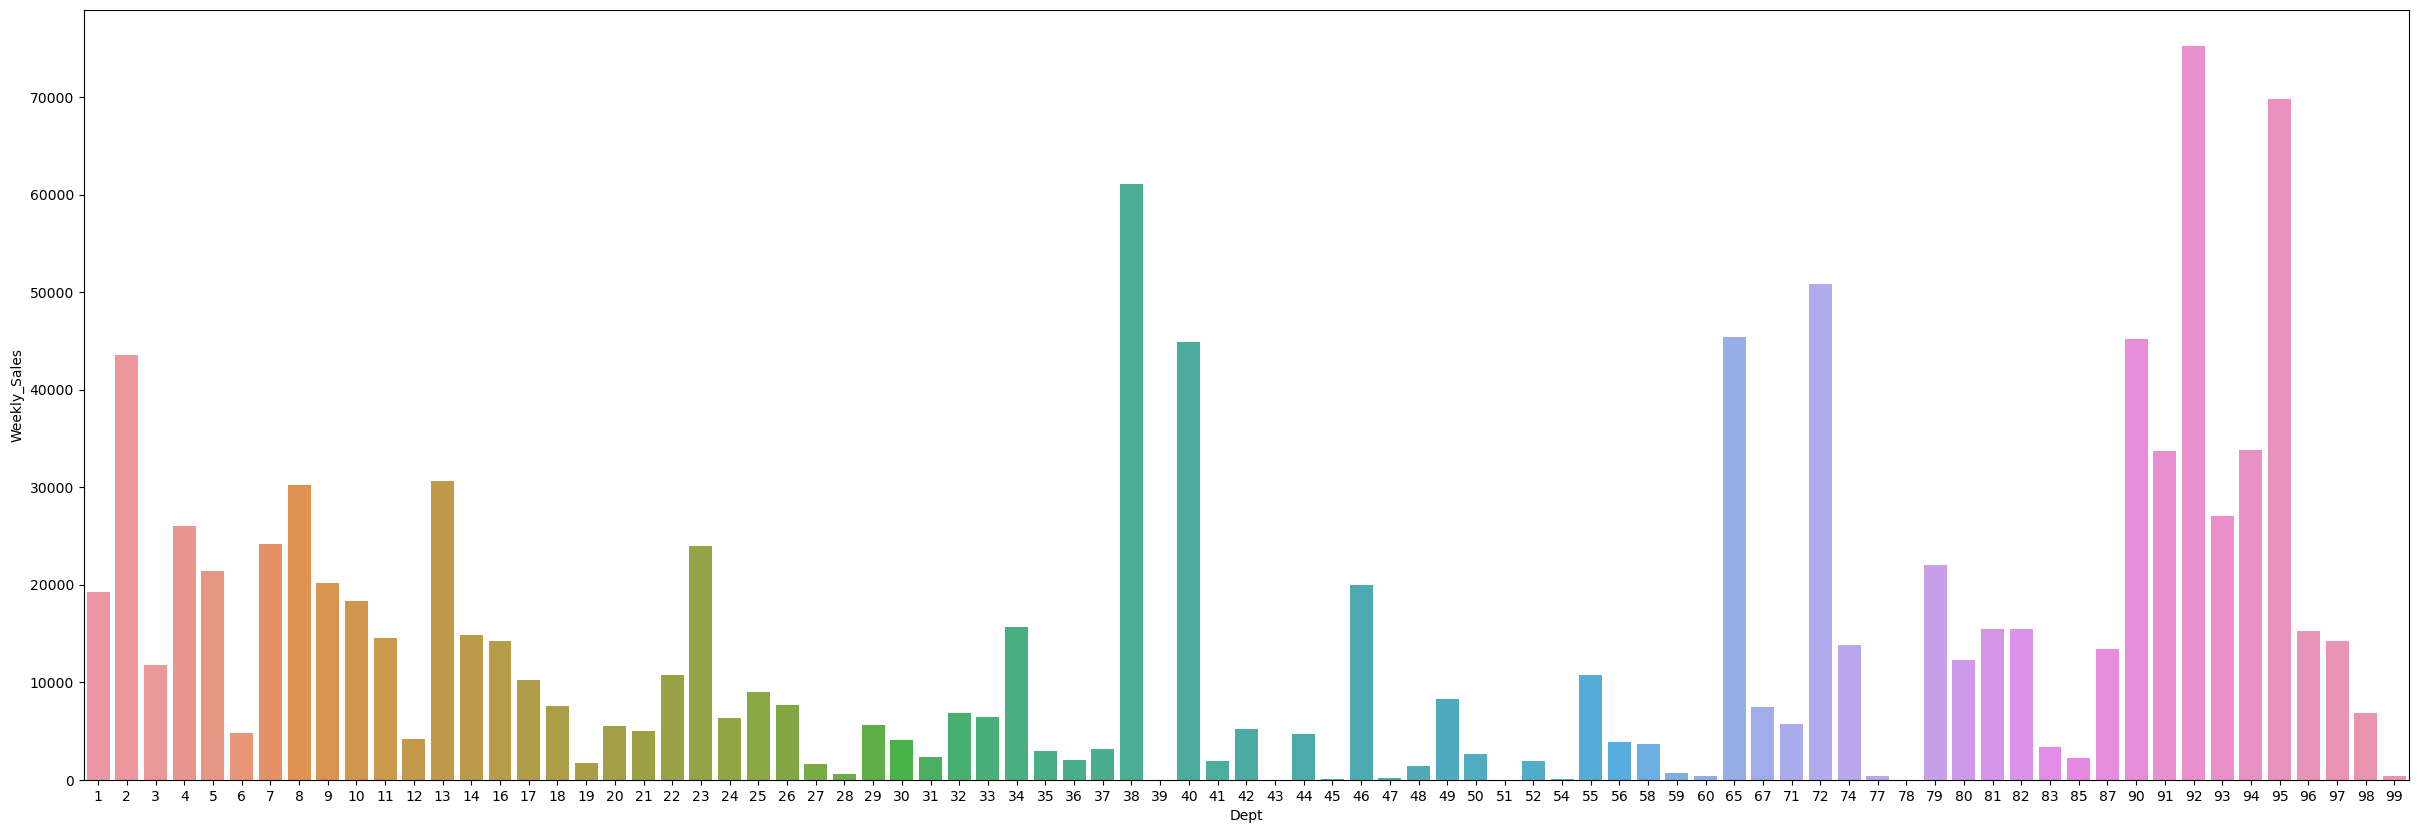

In [41]:
plt.figure(figsize=(30,10))
fig = sea.barplot(x='Dept', y='Weekly_Sales', data=df, ci=None)

From the first graph, it is seen that one department between 60-80(I assume it is 72), has higher sales values. But, when we take the averages, it is seen that department 92 has higher mean sales. Department 72 is seasonal department, I think. It has higher values is some seasons but on average 92 is higher.

### **2. Weekly Sales by Store**

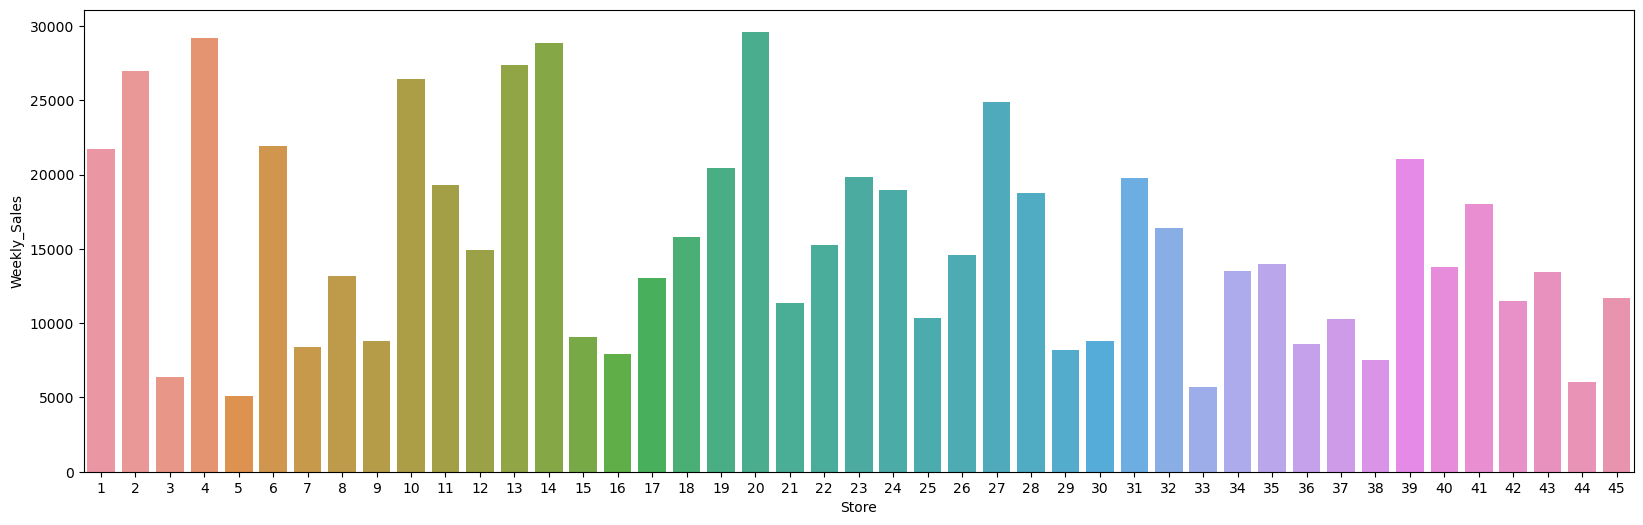

In [42]:
plt.figure(figsize=(20,6))
fig = sea.barplot(x='Store', y='Weekly_Sales', data=df, ci=None)

Same thing happens in stores. From the first graph, some stores has higher sales but on average store 20 is the best and 4 and 14 following it.

### **3. Weekly Sales by Holiday**

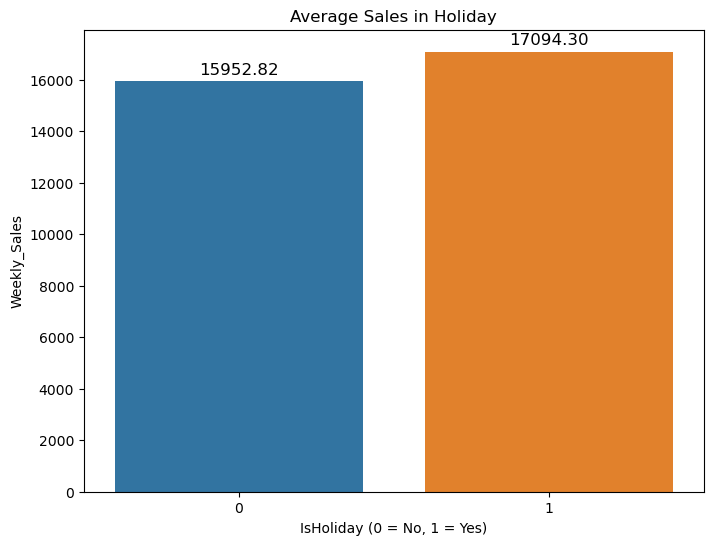

In [43]:
plt.figure(figsize=(8, 6))
ax = sea.barplot(x='IsHoliday', y='Weekly_Sales', data=df, ci=None)

for sales_holiday in ax.patches:
    ax.annotate(f'{sales_holiday.get_height():.2f}',  # format with 2 decimals
                (sales_holiday.get_x() + sales_holiday.get_width() / 2.,
                 sales_holiday.get_height()), 
                ha = 'center', va = 'baseline',
                fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.title('Average Sales in Holiday')
plt.xlabel('IsHoliday (0 = No, 1 = Yes)')
plt.ylabel('Weekly_Sales')
plt.show()

### **4. Christimas Holiday**

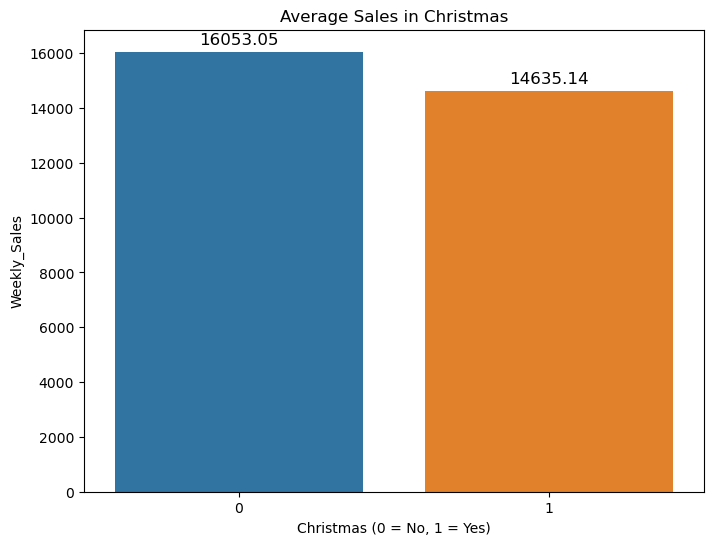

In [44]:
plt.figure(figsize=(8, 6))
ax = sea.barplot(x='Christmas', y='Weekly_Sales', data=df, ci=None)

for sales_christmas in ax.patches:
    ax.annotate(f'{sales_christmas.get_height():.2f}',  # format with 2 decimals
                (sales_christmas.get_x() + sales_christmas.get_width() / 2.,
                 sales_christmas.get_height()), 
                ha = 'center', va = 'baseline',
                fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.title('Average Sales in Christmas')
plt.xlabel('Christmas (0 = No, 1 = Yes)')
plt.ylabel('Weekly_Sales')
plt.show()

### **5. Thanksgiving Holiday**

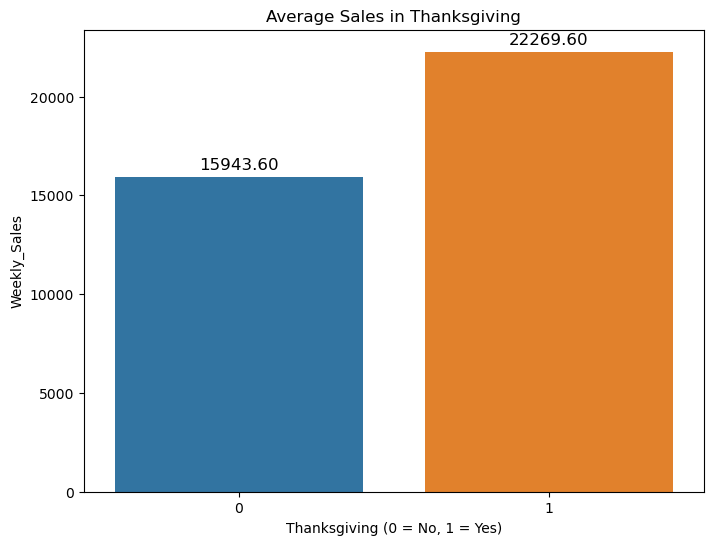

In [45]:
plt.figure(figsize=(8, 6))
ax = sea.barplot(x='Thanksgiving', y='Weekly_Sales', data=df, ci=None)

for sales_thanksgiving in ax.patches:
    ax.annotate(f'{sales_thanksgiving.get_height():.2f}',  # format with 2 decimals
                (sales_thanksgiving.get_x() + sales_thanksgiving.get_width() / 2.,
                 sales_thanksgiving.get_height()), 
                ha = 'center', va = 'baseline',
                fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.title('Average Sales in Thanksgiving')
plt.xlabel('Thanksgiving (0 = No, 1 = Yes)')
plt.ylabel('Weekly_Sales')
plt.show()

### **6. Super-Bowl Holiday**

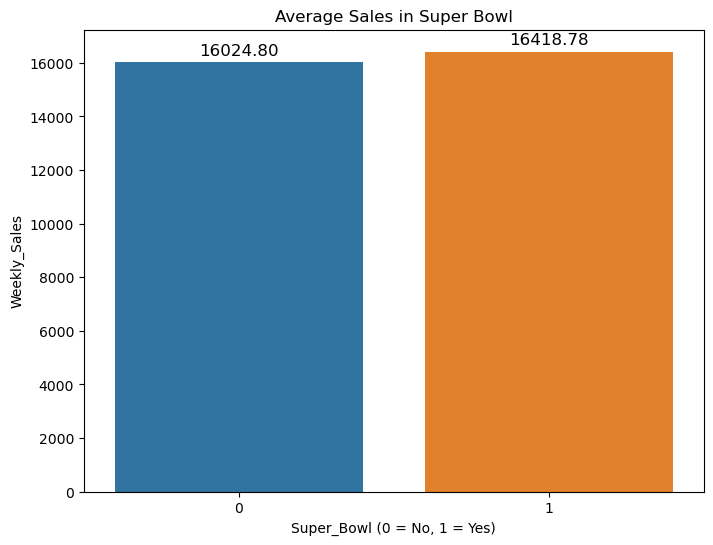

In [46]:
plt.figure(figsize=(8, 6))
ax = sea.barplot(x='Super_Bowl', y='Weekly_Sales', data=df, ci=None)

for sales_superbowl in ax.patches:
    ax.annotate(f'{sales_superbowl.get_height():.2f}',  # format with 2 decimals
                (sales_superbowl.get_x() + sales_superbowl.get_width() / 2.,
                 sales_superbowl.get_height()), 
                ha = 'center', va = 'baseline',
                fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.title('Average Sales in Super Bowl')
plt.xlabel('Super_Bowl (0 = No, 1 = Yes)')
plt.ylabel('Weekly_Sales')
plt.show()

### **7. Labor-day Holiday**

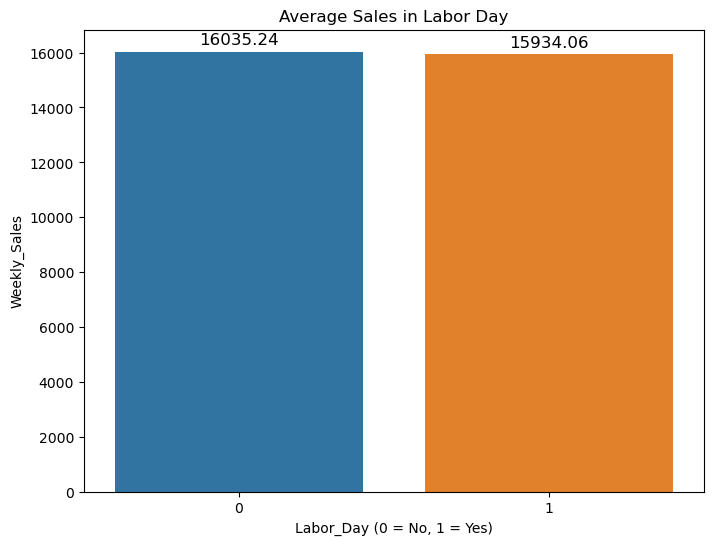

In [47]:
plt.figure(figsize=(8, 6))
ax = sea.barplot(x='Labor_Day', y='Weekly_Sales', data=df, ci=None)

for sales_laborday in ax.patches:
    ax.annotate(f'{sales_laborday.get_height():.2f}',  # format with 2 decimals
                (sales_laborday.get_x() + sales_laborday.get_width() / 2.,
                 sales_laborday.get_height()), 
                ha = 'center', va = 'baseline',
                fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.title('Average Sales in Labor Day')
plt.xlabel('Labor_Day (0 = No, 1 = Yes)')
plt.ylabel('Weekly_Sales')
plt.show()

**Conclution :**

* Labor Day and Christmas do not increase weekly average sales
* There was a slight increase in sales during the Super Bowl.
* There are a significant sales in Thanksgiving
* People generally prefer to buy Christmas gifts 1-2 weeks before Christmas, so it does not change sales in the Christmas week. * There is Black Friday sales in the Thanksgiving week.

### **8. Type Effect on Holiday in Sales**

In [48]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
0    15952.816352
1    17094.300918
Name: Weekly_Sales, dtype: float64

In [49]:
df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()

Christmas  Type
0          1       20174.350209
           2       12301.986116
           3        9570.951973
1          1       18310.167535
           2       11488.988057
           3        8031.520607
Name: Weekly_Sales, dtype: float64

In [50]:
df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()

Labor_Day  Type
0          1       20151.210941
           2       12294.954138
           3        9542.098293
1          1       20004.267422
           2       12084.304642
           3        9893.459258
Name: Weekly_Sales, dtype: float64

In [51]:
df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()

Thanksgiving  Type
0             1       20044.007801
              2       12197.717405
              3        9547.377807
1             1       27397.776346
              2       18733.973971
              3        9696.566616
Name: Weekly_Sales, dtype: float64

In [52]:
df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()

Super_Bowl  Type
0           1       20138.055908
            2       12286.739293
            3        9536.110508
1           1       20612.757674
            2       12467.035506
            3       10179.271884
Name: Weekly_Sales, dtype: float64

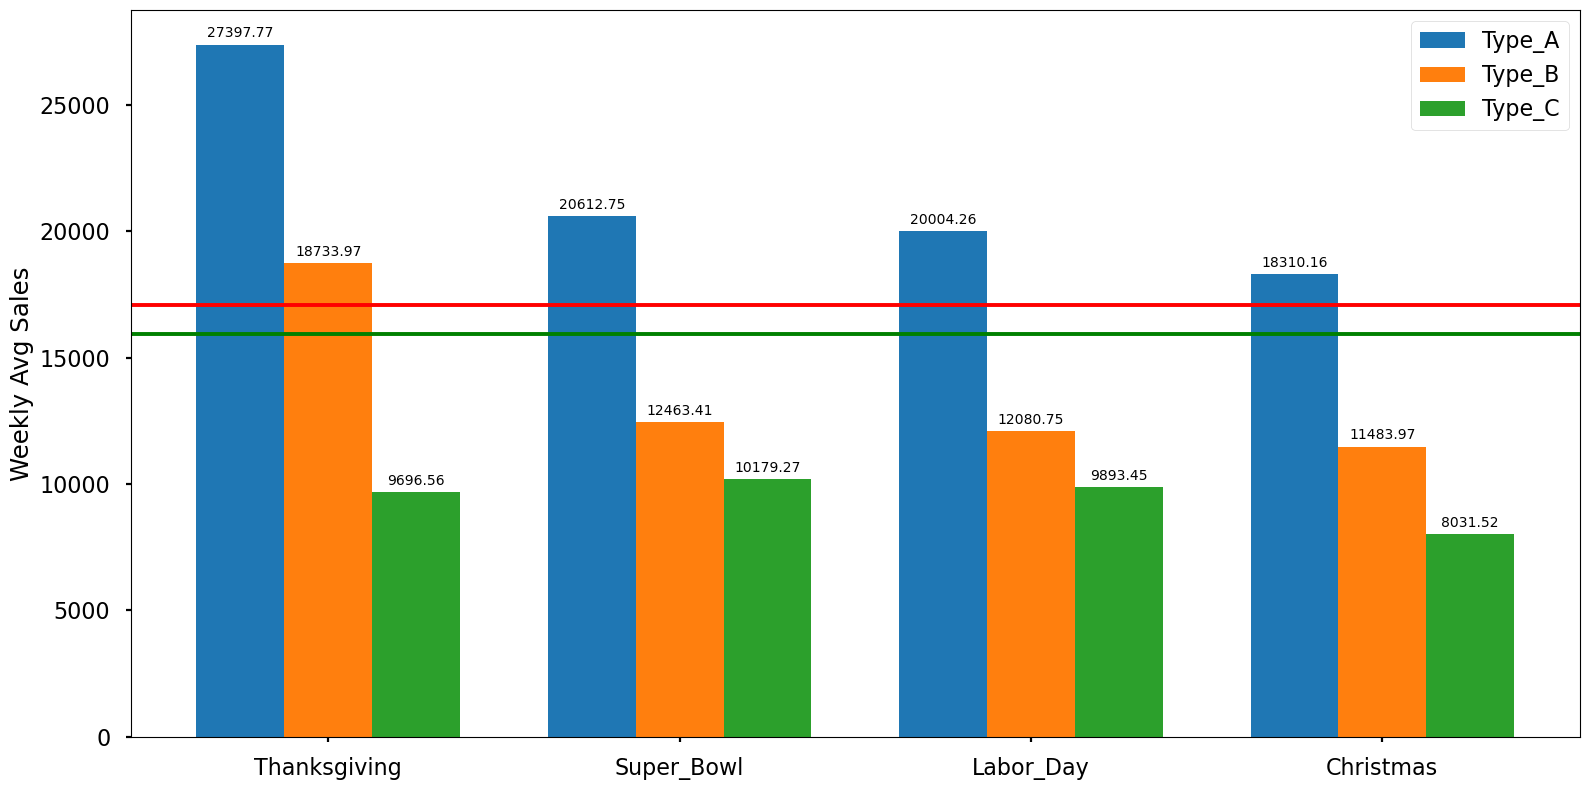

In [53]:
# Plotting avg wekkly sales according to holidays by types
plt.style.use('seaborn-poster')
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x , B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r')
plt.axhline(y=15952.82,color='green')

fig.tight_layout()
plt.show()

In [54]:
df.groupby('Type').describe()['Size'].round(2)

count       mean      min       25%       50%       75%       max  \
Type                                                                         
1     214961.0  182225.39  39690.0  158114.0  202505.0  203819.0  219622.0   
2     162787.0  101796.84  34875.0   93188.0  114533.0  123737.0  140167.0   
3      42464.0   40536.10  39690.0   39690.0   39910.0   41062.0   42988.0   

           std  
Type            
1     41532.66  
2     30944.31  
3      1194.69

**Conclusion**
* Store type A has the highest sales
* Thanksgiving has the highest sales, except for store type C
* Store type C achieves the highest sales on Super Bowl day

### **9. Sales per Year**

In [55]:
df.groupby('year')['Weekly_Sales'].mean() # to see the best years for sales

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

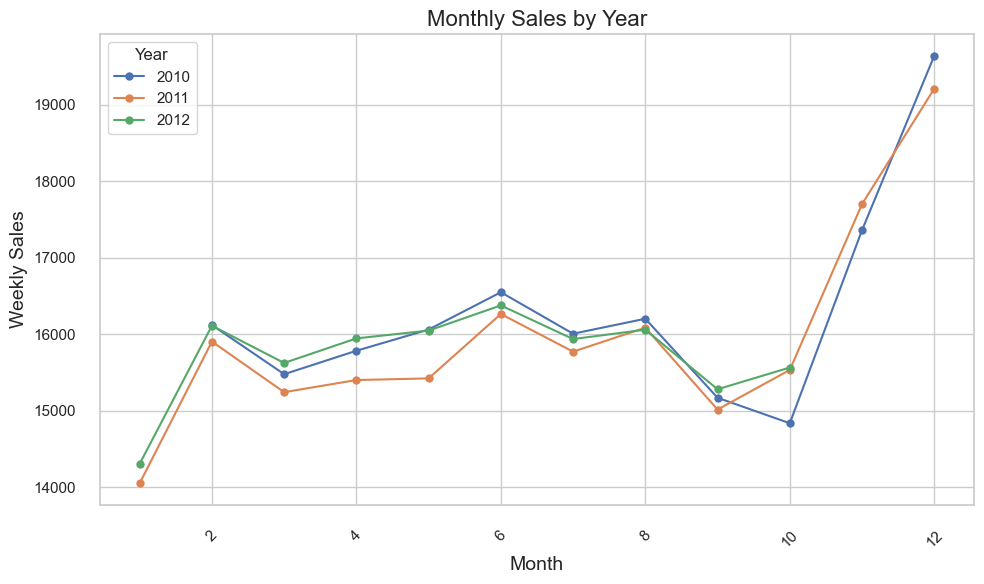

In [73]:
plt.figure(figsize=(10, 6))
plt.title('Monthly Sales by Year', fontsize=16)

monthly_sales = panda.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot(kind='line', marker='o', ax=plt.gca())

plt.xlabel('Month', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.legend(title='Year')
plt.show()

From the graph, it is seen that 2011 has lower sales than 2010 generally. When we look at the mean sales it is seen that 2010 has higher values, but 2012 has no information about November and December which have higher sales. Despite of 2012 has no last two months sales, it's mean is near to 2010. Most probably, it will take the first place if we get 2012 results and add them.

### **10. Sales per Month**

In [56]:
df.groupby('month')['Weekly_Sales'].mean()

month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

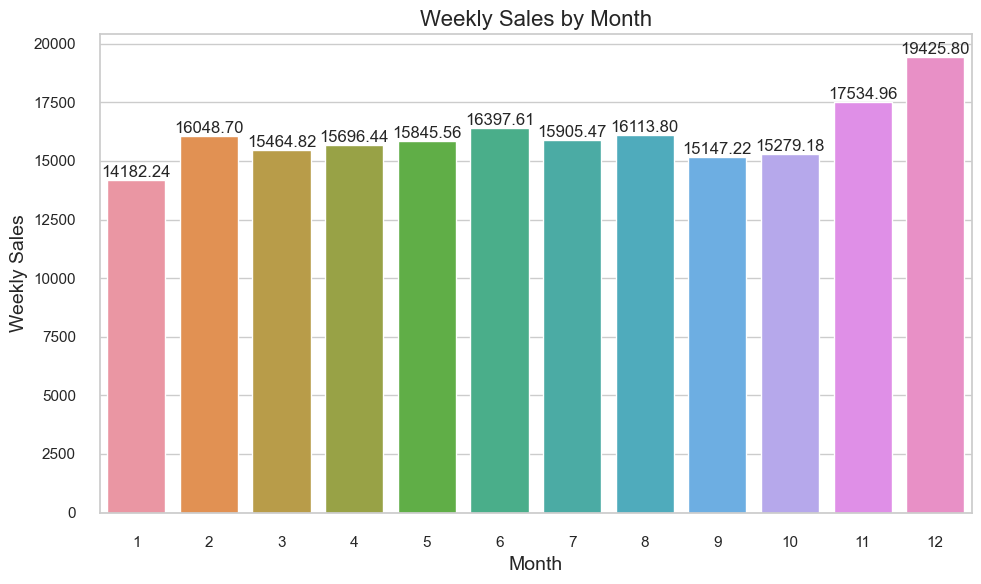

In [72]:
sea.set_theme(style='whitegrid')
plt.figure(figsize=(10, 6))

fig = sea.barplot(x='month', y='Weekly_Sales', data=df, ci=None)

plt.title('Weekly Sales by Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)

for p in fig.patches:
    fig.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

When we look at the graph above, the best sales are in December and November, as expected. The highest values are belongs to Thankgiving holiday but when we take average it is obvious that December has the best value.

### **11. Sales per Week**

In [57]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    26454.164116
47    22269.601768
50    20478.421134
49    18731.794840
22    16856.650245
Name: Weekly_Sales, dtype: float64

Top 5 sales averages by weekly belongs to 1-2 weeks before Christmas, Thanksgiving, Black Friday and end of May, when the schools are closed.

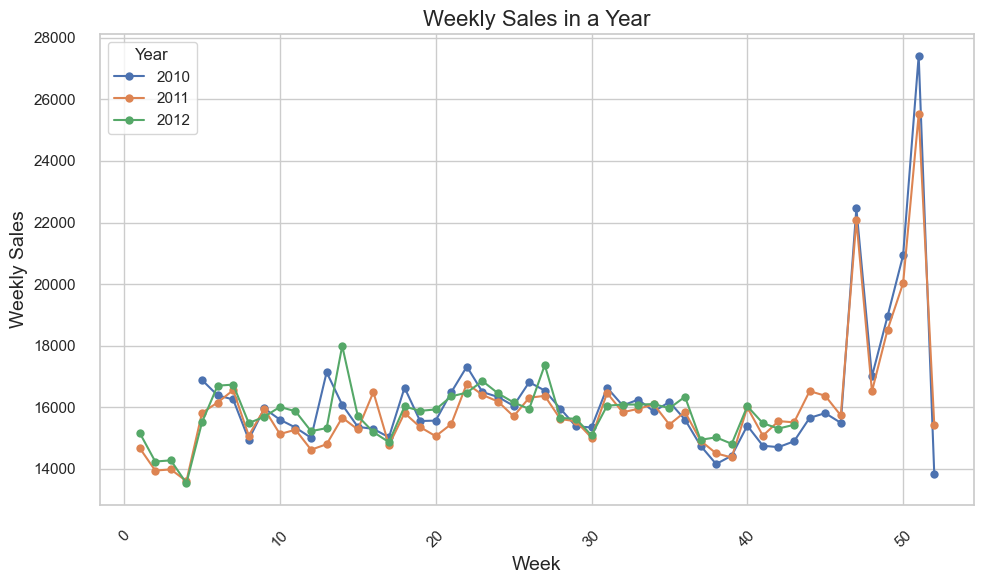

In [76]:
plt.figure(figsize=(10, 6))
plt.title('Weekly Sales in a Year', fontsize=16)

weekly_sales = panda.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot(kind='line', marker='o', ax=plt.gca())

plt.xlabel('Week', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.legend(title='Year')
plt.show()

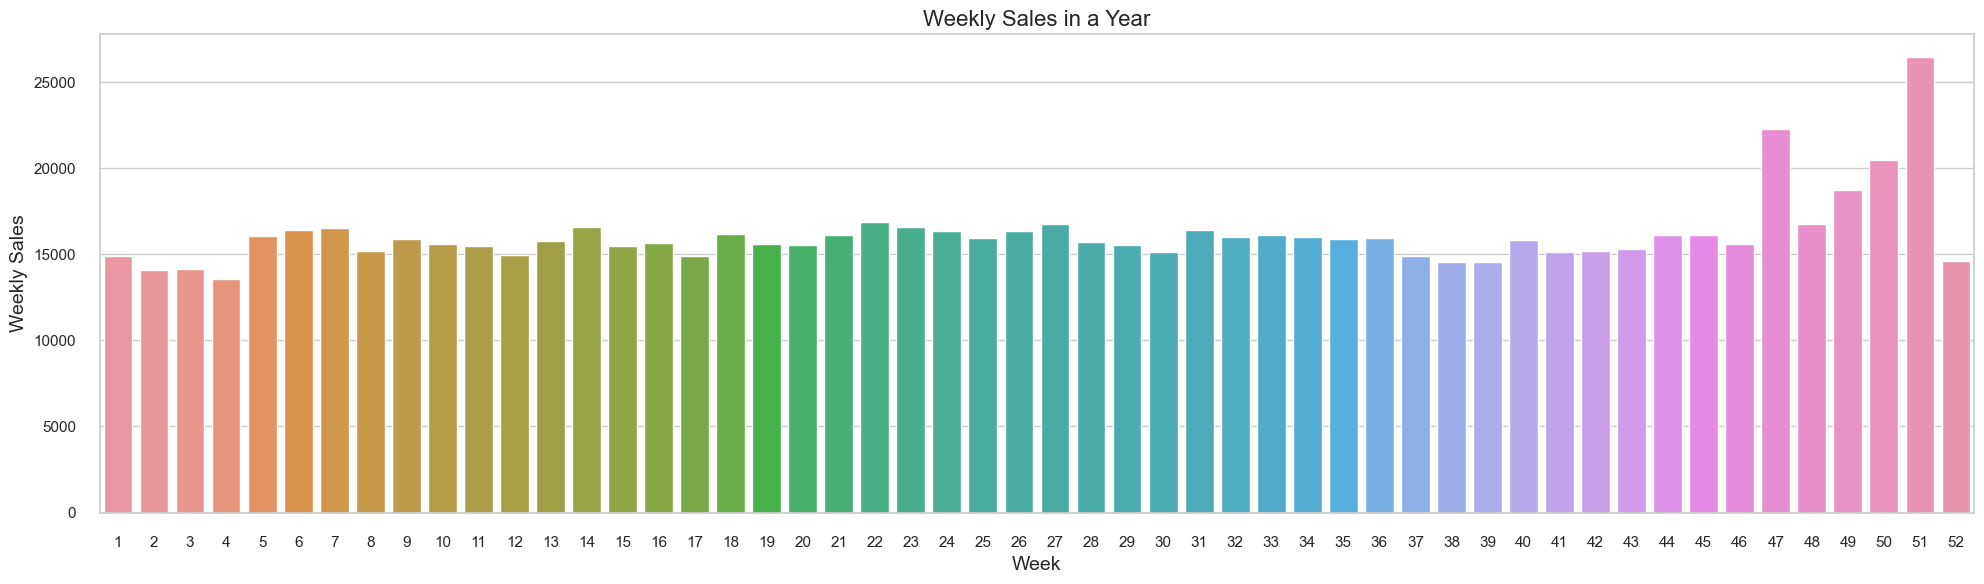

In [77]:
plt.figure(figsize=(20,6))
fig = sea.barplot(x='week', y='Weekly_Sales', data=df, ci=None)

plt.title('Weekly Sales in a Year', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)

plt.tight_layout()
plt.show()

From graphs, it is seen that 51th week and 47th weeks have significantly higher averages as Christmas, Thankgiving and Black Friday effects.

### **12. Weekly Sales by Fuel_Price**

<Figure size 800x600 with 0 Axes>

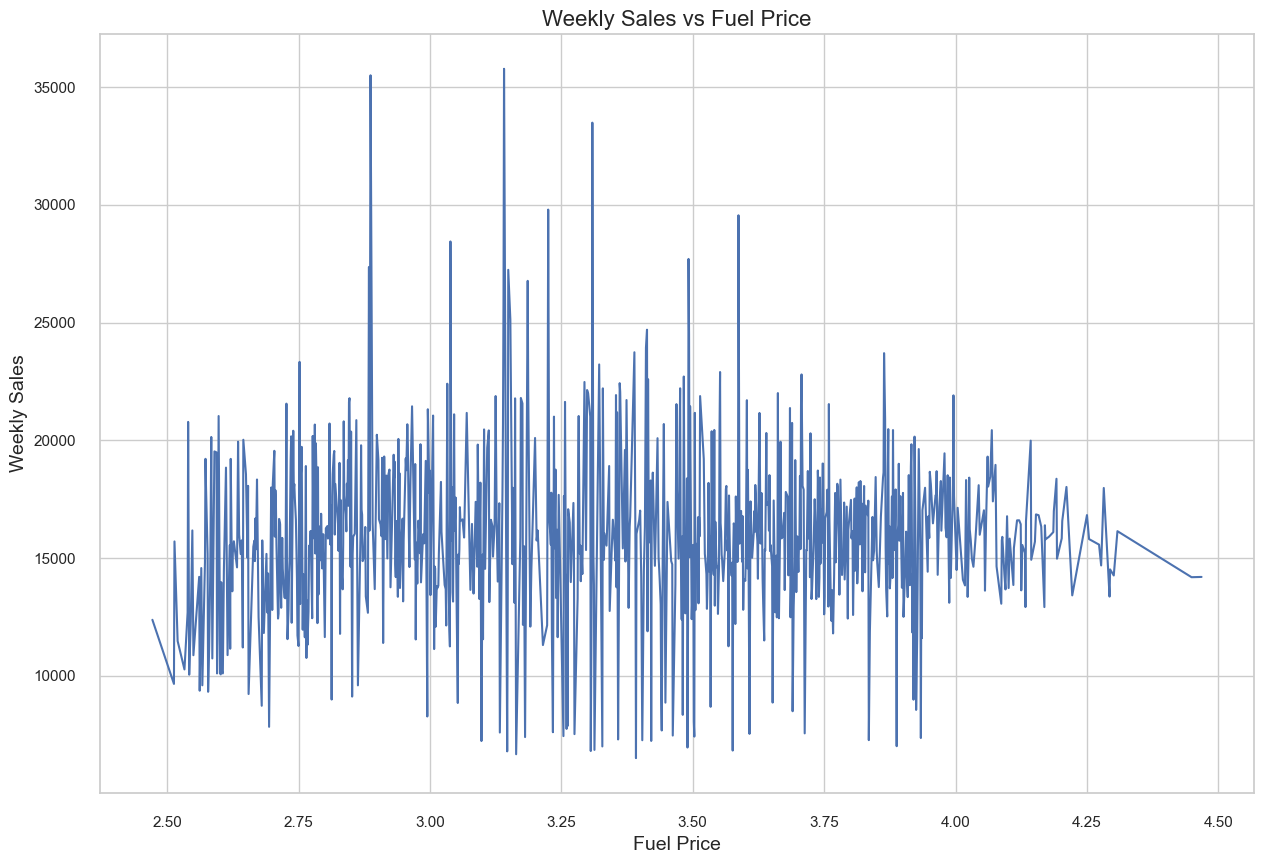

In [80]:
plt.figure(figsize=(8, 6))

fuel_price = panda.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot(title='Weekly Sales vs Fuel Price', legend=False)

plt.title('Weekly Sales vs Fuel Price', fontsize=16)
plt.xlabel('Fuel Price', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

### **13. Weekly Sales by Temperature**

<Figure size 800x600 with 0 Axes>

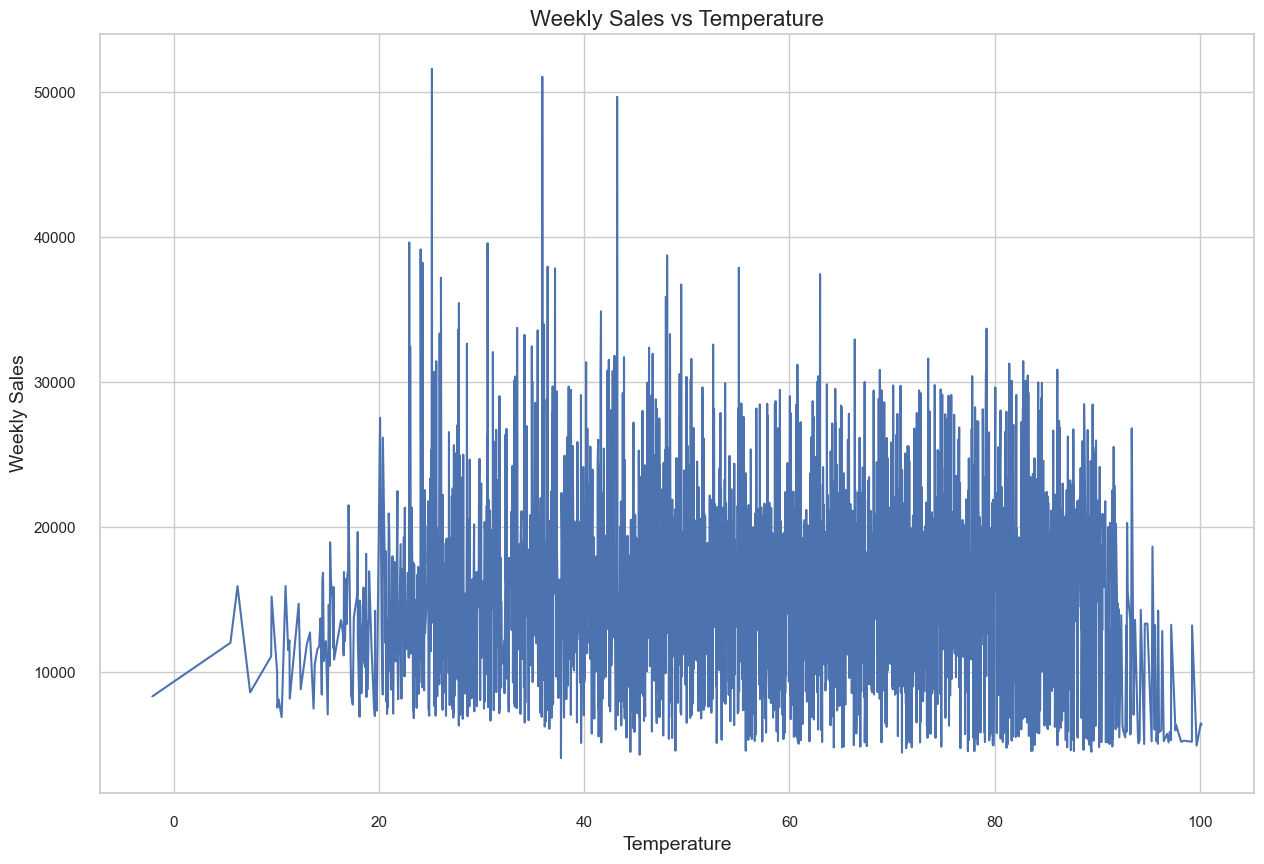

In [82]:
plt.figure(figsize=(8, 6))

temp = panda.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp.plot(title='Weekly Sales vs Temperature', legend=False)

plt.title('Weekly Sales vs Temperature', fontsize=16)
plt.xlabel('Temperature', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

### **14. Weekly Sales by CPI**

<Figure size 800x600 with 0 Axes>

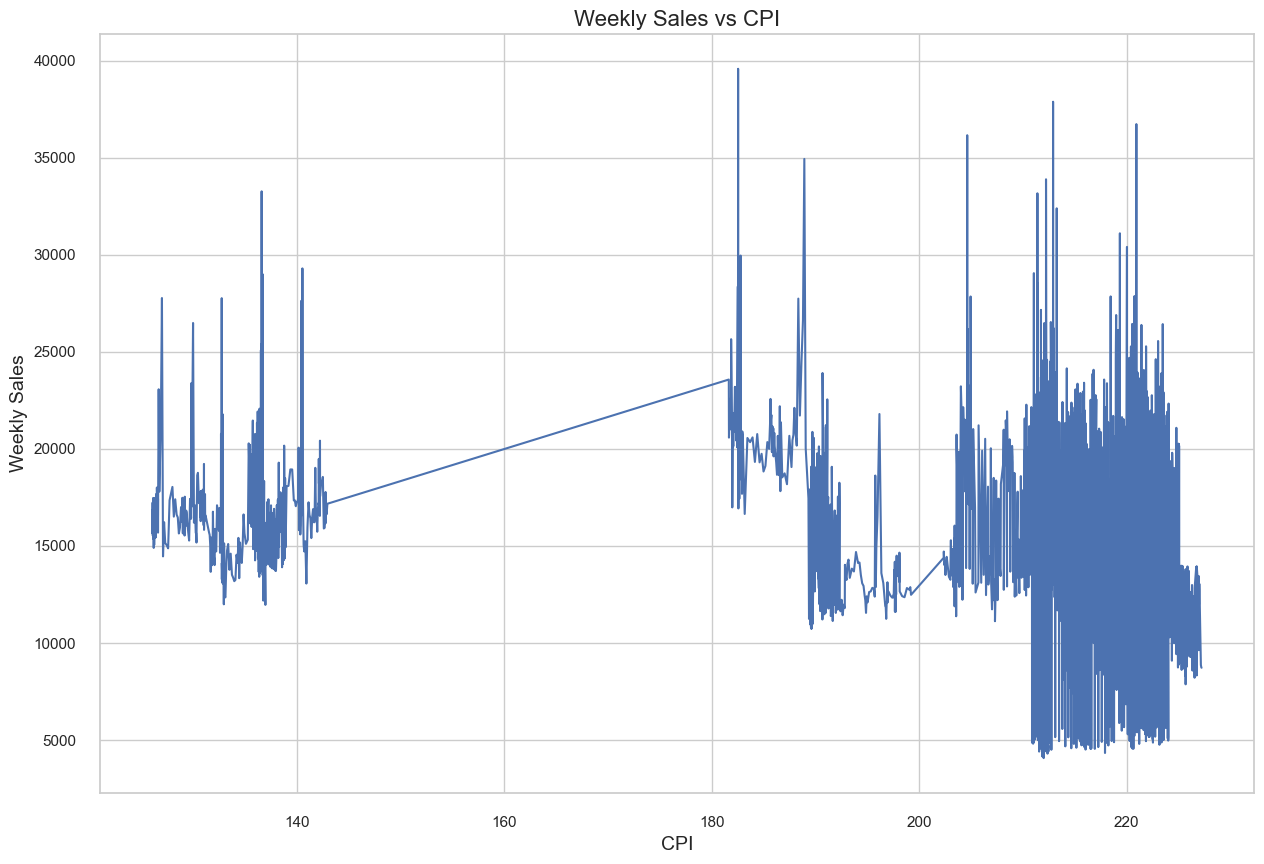

In [83]:
plt.figure(figsize=(8, 6))

CPI = panda.pivot_table(df, values = "Weekly_Sales", index= "CPI")
CPI.plot(title='Weekly Sales vs CPI', legend=False)

plt.title('Weekly Sales vs CPI', fontsize=16)
plt.xlabel('CPI', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

### **15. Weekly Sales by Unemployment**

<Figure size 800x600 with 0 Axes>

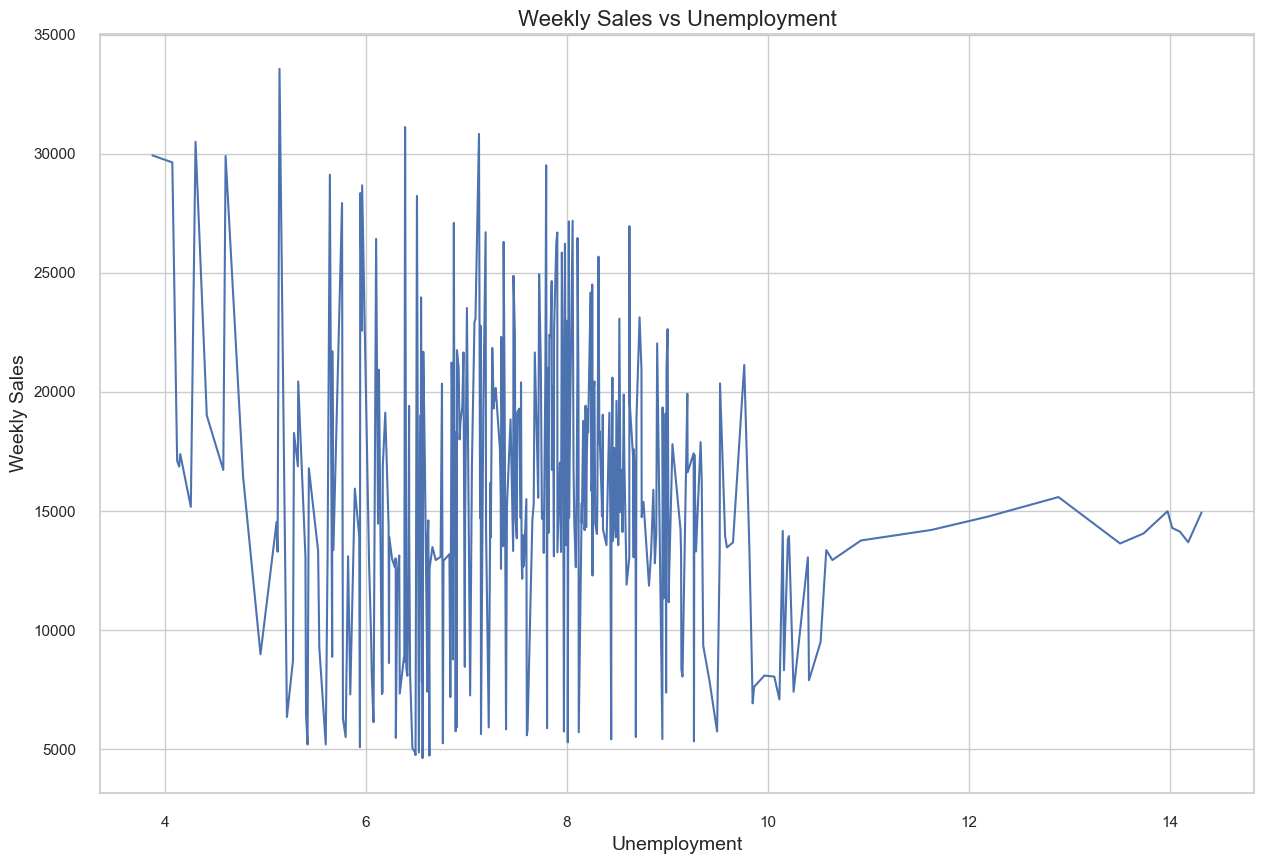

In [84]:
plt.figure(figsize=(8, 6))

unemployment = panda.pivot_table(df, values = "Weekly_Sales", index= "Unemployment")
unemployment.plot(title='Weekly Sales vs Unemployment', legend=False)

plt.title('Weekly Sales vs Unemployment', fontsize=16)
plt.xlabel('Unemployment', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

From graphs, it is seen that there are no significant patterns between CPI, temperature, unemployment rate, fuel price vs weekly sales. There is no data for CPI between 140-180 also.

## **Features Selection**

In [44]:
df = df.drop(columns=['Temperature','MarkDown4','MarkDown5','CPI','Unemployment','Fuel_Price'])
df = df.drop(columns=['week','month','year'])

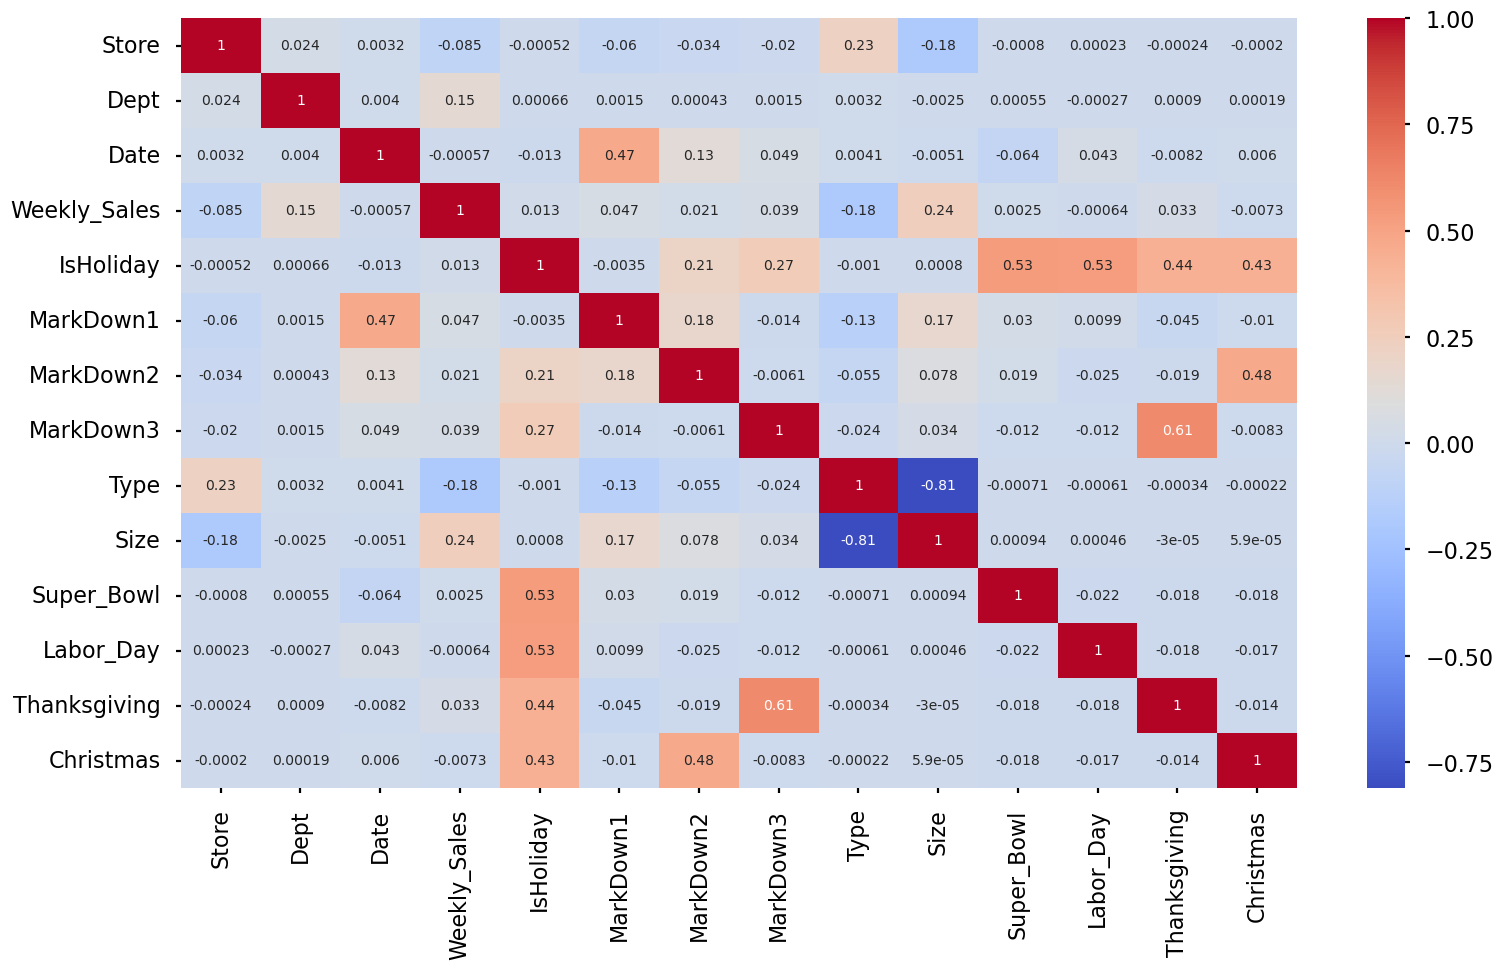

In [58]:
plt.figure(figsize=(18,10))
sea.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

* Temperature, Unemployment, CPI, and Fuel Price have no significant effect on weekly sales.
* Markdown 4 and 5 are highly correlated with Markdown 1, which could indicate multicollinearity.
* Month, week, and year are also highly correlated with each other, which could indicate multicollinearity.

**Save into a new file**

In [45]:
df.to_csv('df_clean - Walmart Sales Forecast.csv')

## Model and Evaluating 

In [46]:
df_models = panda.read_csv('df_clean - Walmart Sales Forecast.csv')

In [47]:
df_models.head(3)

Unnamed: 0  Store  Dept        Date  Weekly_Sales  IsHoliday  MarkDown1  \
0           0      1     1  2010-02-05      24924.50          0        0.0   
1           1      1     2  2010-02-05      50605.27          0        0.0   
2           2      1     3  2010-02-05      13740.12          0        0.0   

   MarkDown2  MarkDown3  Type    Size  Super_Bowl  Labor_Day  Thanksgiving  \
0        0.0        0.0     1  151315           0          0             0   
1        0.0        0.0     1  151315           0          0             0   
2        0.0        0.0     1  151315           0          0             0   

   Christmas  
0          0  
1          0  
2          0

In [48]:
df_models.drop(columns=['Unnamed: 0'],inplace=True)

In [49]:
df_models["Date"] = panda.to_datetime(df_models["Date"])

In [50]:
df_models.head(3)

Store  Dept       Date  Weekly_Sales  IsHoliday  MarkDown1  MarkDown2  \
0      1     1 2010-02-05      24924.50          0        0.0        0.0   
1      1     2 2010-02-05      50605.27          0        0.0        0.0   
2      1     3 2010-02-05      13740.12          0        0.0        0.0   

   MarkDown3  Type    Size  Super_Bowl  Labor_Day  Thanksgiving  Christmas  
0        0.0     1  151315           0          0             0          0  
1        0.0     1  151315           0          0             0          0  
2        0.0     1  151315           0          0             0          0

In [51]:
df_models.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420212 entries, 0 to 420211
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         420212 non-null  int64         
 1   Dept          420212 non-null  int64         
 2   Date          420212 non-null  datetime64[ns]
 3   Weekly_Sales  420212 non-null  float64       
 4   IsHoliday     420212 non-null  int64         
 5   MarkDown1     420212 non-null  float64       
 6   MarkDown2     420212 non-null  float64       
 7   MarkDown3     420212 non-null  float64       
 8   Type          420212 non-null  int64         
 9   Size          420212 non-null  int64         
 10  Super_Bowl    420212 non-null  int64         
 11  Labor_Day     420212 non-null  int64         
 12  Thanksgiving  420212 non-null  int64         
 13  Christmas     420212 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(9)
memory usage: 44.9 MB


In [52]:
# The dataset is arranged in order to facilitate the train-test process of the machine learning model

df_models = df_models.sort_values(by='Date', ascending=True)

In [53]:
df_models.head(3)

Store  Dept       Date  Weekly_Sales  IsHoliday  MarkDown1  MarkDown2  \
0           1     1 2010-02-05      24924.50          0        0.0        0.0   
329781     35     3 2010-02-05      14612.19          0        0.0        0.0   
329782     35     4 2010-02-05      26323.15          0        0.0        0.0   

        MarkDown3  Type    Size  Super_Bowl  Labor_Day  Thanksgiving  \
0             0.0     1  151315           0          0             0   
329781        0.0     2  103681           0          0             0   
329782        0.0     2  103681           0          0             0   

        Christmas  
0               0  
329781          0  
329782          0

### **Creating Train-Test Splits**

Our date column has continuos values, to keep the date features continue, I will not take random splitting. so, I split data manually according to 70%.

In [54]:
# Separating the data without shuffling
train_data, test_data = train_test_split(df_models, test_size=0.3, shuffle=False)

target = "Weekly_Sales"
features_models = df_models.columns[df_models.columns != target]    # All columns except weekly sales. 

X_train = train_data[features_models]
X_test = test_data[features_models]
y_train = train_data[target]
y_test = test_data[target]

In [55]:
# backup dataframe that contains features that used into the models

features_backup = df_models[features_models]

## **Features Importance**

In [78]:
features_importance = df_models.copy()

In [79]:
features_importance['Date_Timestamp'] = features_importance['Date'].astype('int64') // 10**9  # Mengubah ke timestamp
features_importance = features_importance.drop(columns=['Date'])

target = "Weekly_Sales"
features = features_importance.columns[features_importance.columns != target]

train_data, test_data = train_test_split(features_importance, test_size=0.3, shuffle=False)

X_train = train_data[features]
X_test = test_data[features]
y_train = train_data[target]
y_test = test_data[target]

print(f'Training data size: {X_train.shape[0]}')
print(f'Testing data size: {X_test.shape[0]}')

Training data size: 294148
Testing data size: 126064


In [80]:
! pip install xgboost
import xgboost as xgb

# Train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Obtain feature importances
importances = model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = panda.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort by feature importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

           Feature  Importance
10    Thanksgiving    0.340558
1             Dept    0.244538
7             Size    0.215298
0            Store    0.059961
6             Type    0.053334
5        MarkDown3    0.036696
12  Date_Timestamp    0.021180
4        MarkDown2    0.009214
3        MarkDown1    0.006649
11       Christmas    0.005474
8       Super_Bowl    0.004263
2        IsHoliday    0.002132
9        Labor_Day    0.000704


In [81]:
Xupdate_train = X_train.drop(columns=['Labor_Day'], axis=1)
Xupdate_test = X_test.drop(columns=['Labor_Day'], axis=1)

In [82]:
def wmae(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

# Train the model using the updated data (Xupdate_train)
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(Xupdate_train, y_train)

# prediction
y_pred = model.predict(Xupdate_test)

# The 'IsHoliday' column as weights, with 5 for holidays and 1 for regular days
weights = Xupdate_test['IsHoliday'].apply(lambda x: 5 if x == 1 else 1)

# WMAE values
wmae_value = wmae(y_test, y_pred, weights)

print(f'Weighted Mean Absolute Error (WMAE): {wmae_value}')

Weighted Mean Absolute Error (WMAE): 4614.699325492158


**Conclusion :**
* The result of WMAE is 4614.69
* This metric shows how far the model's predictions deviate from the true values
* It indicates that there is an average prediction error of 4614.69 units in sales during holidays, compared to the actual sales during holidays.

## Model and Evaluating - With Pre-processing

In [2]:
df_prepro = panda.read_csv('df_clean - Walmart Sales Forecast.csv')

In [4]:
df_prepro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420212 entries, 0 to 420211
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    420212 non-null  int64  
 1   Store         420212 non-null  int64  
 2   Dept          420212 non-null  int64  
 3   Date          420212 non-null  object 
 4   Weekly_Sales  420212 non-null  float64
 5   IsHoliday     420212 non-null  int64  
 6   MarkDown1     420212 non-null  float64
 7   MarkDown2     420212 non-null  float64
 8   MarkDown3     420212 non-null  float64
 9   Type          420212 non-null  int64  
 10  Size          420212 non-null  int64  
 11  Super_Bowl    420212 non-null  int64  
 12  Labor_Day     420212 non-null  int64  
 13  Thanksgiving  420212 non-null  int64  
 14  Christmas     420212 non-null  int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 48.1+ MB


In [5]:
df_prepro.head(5)

Unnamed: 0  Store  Dept        Date  Weekly_Sales  IsHoliday  MarkDown1  \
0           0      1     1  2010-02-05      24924.50          0        0.0   
1           1      1     2  2010-02-05      50605.27          0        0.0   
2           2      1     3  2010-02-05      13740.12          0        0.0   
3           3      1     4  2010-02-05      39954.04          0        0.0   
4           4      1     5  2010-02-05      32229.38          0        0.0   

   MarkDown2  MarkDown3  Type    Size  Super_Bowl  Labor_Day  Thanksgiving  \
0        0.0        0.0     1  151315           0          0             0   
1        0.0        0.0     1  151315           0          0             0   
2        0.0        0.0     1  151315           0          0             0   
3        0.0        0.0     1  151315           0          0             0   
4        0.0        0.0     1  151315           0          0             0   

   Christmas  
0          0  
1          0  
2          0  
3          0  
4          0

In [3]:
df_prepro.drop(columns=['Unnamed: 0'],inplace=True)

In [4]:
df_prepro.drop(columns=['Labor_Day'],inplace=True)

In [5]:
df_prepro['Date'] = panda.to_datetime(df_prepro['Date'])
df_prepro['Date_Timestamp'] = df_prepro['Date'].astype('int64') // 10**9  # Change to timestamp
df_prepro = df_prepro.drop(columns=['Date'])

In [6]:
df_prepro.head(3)

Store  Dept  Weekly_Sales  IsHoliday  MarkDown1  MarkDown2  MarkDown3  \
0      1     1      24924.50          0        0.0        0.0        0.0   
1      1     2      50605.27          0        0.0        0.0        0.0   
2      1     3      13740.12          0        0.0        0.0        0.0   

   Type    Size  Super_Bowl  Thanksgiving  Christmas  Date_Timestamp  
0     1  151315           0             0          0      1265328000  
1     1  151315           0             0          0      1265328000  
2     1  151315           0             0          0      1265328000

In [7]:
df_prepro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420212 entries, 0 to 420211
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Store           420212 non-null  int64  
 1   Dept            420212 non-null  int64  
 2   Weekly_Sales    420212 non-null  float64
 3   IsHoliday       420212 non-null  int64  
 4   MarkDown1       420212 non-null  float64
 5   MarkDown2       420212 non-null  float64
 6   MarkDown3       420212 non-null  float64
 7   Type            420212 non-null  int64  
 8   Size            420212 non-null  int64  
 9   Super_Bowl      420212 non-null  int64  
 10  Thanksgiving    420212 non-null  int64  
 11  Christmas       420212 non-null  int64  
 12  Date_Timestamp  420212 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 41.7 MB


* **Handling Outliers**

In [11]:
# Split data
train_data, test_data = train_test_split(df_prepro, test_size=0.3, shuffle=False)

# Define the target and features
target = "Weekly_Sales"
features_models = df_prepro.columns[df_prepro.columns != target]     # All columns except the target.

X_train = train_data[features_models]
X_test = test_data[features_models]
y_train = train_data[target]
y_test = test_data[target]

# Handle outliers in the target column (Weekly_Sales) using IQR
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR    # Determine the lower and upper bounds to remove outliers
upper_bound = Q3 + 1.5 * IQR

mask = (y_train >= lower_bound) & (y_train <= upper_bound) # Filter outliers from y_train and the related features in X_train
X_train_filtered = X_train[mask]
y_train_filtered = y_train[mask]

# Check the data size after removing outliers
print(f'Size of the training data after removing outliers: {X_train_filtered.shape}')

Size of the training data after removing outliers: (269555, 12)


In [12]:
# WMAE Function
def wmae(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

# Create and train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train_filtered, y_train_filtered)

# Prediction
y_pred = model.predict(X_test)

# The 'IsHoliday' column as weights, with 5 for holidays and 1 for regular days
weights = X_test['IsHoliday'].apply(lambda x: 5 if x == 1 else 1)

# WMAE values
wmae_value = wmae(y_test, y_pred, weights)
print(f'Weighted Mean Absolute Error (WMAE): {wmae_value}')

Weighted Mean Absolute Error (WMAE): 5916.870610431946


* **Normalization**

In [25]:
df_prepro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420212 entries, 0 to 420211
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Store           420212 non-null  int64  
 1   Dept            420212 non-null  int64  
 2   Weekly_Sales    420212 non-null  float64
 3   IsHoliday       420212 non-null  int32  
 4   MarkDown1       420212 non-null  float64
 5   MarkDown2       420212 non-null  float64
 6   MarkDown3       420212 non-null  float64
 7   Type            420212 non-null  int64  
 8   Size            420212 non-null  int64  
 9   Super_Bowl      420212 non-null  int32  
 10  Labor_Day       420212 non-null  int32  
 11  Thanksgiving    420212 non-null  int32  
 12  Christmas       420212 non-null  int32  
 13  Date_Timestamp  420212 non-null  int64  
dtypes: float64(4), int32(5), int64(5)
memory usage: 36.9 MB


In [8]:
df_prepro.head(3)

Store  Dept  Weekly_Sales  IsHoliday  MarkDown1  MarkDown2  MarkDown3  \
0      1     1      24924.50          0        0.0        0.0        0.0   
1      1     2      50605.27          0        0.0        0.0        0.0   
2      1     3      13740.12          0        0.0        0.0        0.0   

   Type    Size  Super_Bowl  Thanksgiving  Christmas  Date_Timestamp  
0     1  151315           0             0          0      1265328000  
1     1  151315           0             0          0      1265328000  
2     1  151315           0             0          0      1265328000

In [9]:
train_data, test_data = train_test_split(df_prepro, test_size=0.3, shuffle=False)

target = "Weekly_Sales"
features_models = df_prepro.columns[df_prepro.columns != target]    # All columns except weekly sales. 

X_train = train_data[features_models]
X_test = test_data[features_models]
y_train = train_data[target]
y_test = test_data[target]

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Normalization of numerical features after splitting the data
scaler = MinMaxScaler()
normalize = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'Size']

# Normalization is performed only on the training data, and transformation is applied to the testing data
X_train[normalize] = scaler.fit_transform(X_train[normalize])
X_test[normalize] = scaler.transform(X_test[normalize])

# Check the results of normalization
print(X_train[normalize].describe())

           MarkDown1      MarkDown2      MarkDown3           Size
count  294148.000000  294148.000000  294148.000000  294148.000000
mean        0.032481       0.012169       0.004078       0.595697
std         0.072264       0.053695       0.043103       0.304460
min         0.000000       0.000000       0.000000       0.000000
25%         0.000000       0.002536       0.000205       0.431173
50%         0.000000       0.002536       0.000205       0.569925
75%         0.040578       0.002620       0.000245       0.914045
max         1.000000       1.000000       1.000000       1.000000


In [11]:
# Model XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# The 'IsHoliday' column as weights, with 5 for holidays and 1 for regular days
weights = X_test['IsHoliday'].apply(lambda x: 5 if x == 1 else 1)

# WMAE Function
def wmae(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

# WMAE values
wmae_value = wmae(y_test, y_pred, weights)

print(f'Weighted Mean Absolute Error (WMAE): {wmae_value}')

Weighted Mean Absolute Error (WMAE): 5746.482409996697


* **Standarization**

In [6]:
train_data, test_data = train_test_split(df_prepro, test_size=0.3, shuffle=False)

target = "Weekly_Sales"
features_models = df_prepro.columns[df_prepro.columns != target]  # All columns except weekly sales 

X_train = train_data[features_models]
X_test = test_data[features_models]
y_train = train_data[target]
y_test = test_data[target]

In [7]:
from sklearn.preprocessing import StandardScaler

# Standardization (StandardScaler) on numerical features after data split
standardizer = StandardScaler()
standardize = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'Size']

# Standardization is performed only on the training data, and the transformation is applied to the test data.
X_train_standardized = X_train.copy()
X_test_standardized = X_test.copy()
X_train_standardized[standardize] = standardizer.fit_transform(X_train_standardized[standardize])
X_test_standardized[standardize] = standardizer.transform(X_test_standardized[standardize])

print("Standardized data:")
print(X_train_standardized[standardize].describe())

Standardized data:
          MarkDown1     MarkDown2     MarkDown3          Size
count  2.941480e+05  2.941480e+05  2.941480e+05  2.941480e+05
mean  -1.097647e-16  1.623281e-17 -1.893827e-17  1.978856e-16
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00
min   -4.494752e-01 -2.266304e-01 -9.461363e-02 -1.956571e+00
25%   -4.494752e-01 -1.793965e-01 -8.984774e-02 -5.403787e-01
50%   -4.494752e-01 -1.793965e-01 -8.984774e-02 -8.464703e-02
75%    1.120460e-01 -1.778325e-01 -8.892405e-02  1.045615e+00
max    1.338870e+01  1.839701e+01  2.310586e+01  1.327936e+00


In [8]:
# XGBoost model using standardized data
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train_standardized, y_train)

# Prediction
y_pred_standardized = model.predict(X_test_standardized)

# The 'IsHoliday' column as weights, with 5 for holidays and 1 for regular days
weights = X_test_standardized['IsHoliday'].apply(lambda x: 5 if x == 1 else 1)

# WMAE Function
def wmae(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

# WMAE for standardized data
wmae_value_standardized = wmae(y_test, y_pred_standardized, weights)

#  WMAE (standarisasi) Result
print(f'Weighted Mean Absolute Error (WMAE) - Standardized: {wmae_value_standardized}')

Weighted Mean Absolute Error (WMAE) - Standardized: 5746.482409996697


* **Lag Features dan Rolling Averages**

In [3]:
df_prepro = panda.read_csv('df_clean - Walmart Sales Forecast.csv')

# Removing unnecessary columns
df_prepro.drop(columns=['Unnamed: 0'], inplace=True)
df_prepro.drop(columns=['Labor_Day'],inplace=True)

# Changing the Data Type
df_prepro['Type'] = df_prepro['Type'].apply(lambda x: 1 if x == 'A' else 2 if x == 'B' else 3)
boolean_cols = ['Super_Bowl', 'Thanksgiving', 'Christmas', 'IsHoliday']
for col in boolean_cols:
    df_prepro[col] = df_prepro[col].astype(bool).astype(int)

# Changing the date column
df_prepro['Date'] = panda.to_datetime(df_prepro['Date'])
df_prepro['Date_Timestamp'] = df_prepro['Date'].astype('int64') // 10**9      # Converting to timestamp
df_prepro.drop(columns=['Date'], inplace=True)

In [4]:
# Calculate Lag Features
for lag in range(1, 4):  # For example, 3 lags
    df_prepro[f'Weekly_Sales_Lag_{lag}'] = df_prepro['Weekly_Sales'].shift(lag)

# Calculate Rolling Averages
df_prepro['Weekly_Sales_Rolling_Mean'] = df_prepro['Weekly_Sales'].rolling(window=3).mean()    # For example, a window of 3

In [5]:
# Separating features and target
train_data, test_data = train_test_split(df_prepro, test_size=0.3, shuffle=False)

target = "Weekly_Sales"
features_models = df_prepro.columns[df_prepro.columns != target]

X_train = train_data[features_models]
y_train = train_data[target]
X_test = test_data[features_models]
y_test = test_data[target]

# Check the size
print("Size of X_train:", X_train.shape)
print("Size of y_train:", y_train.shape)
print("Size of X_test:", X_test.shape)
print("Size of y_test:", X_test.shape)

Size of X_train: (294148, 16)
Size of y_train: (294148,)
Size of X_test: (126064, 16)
Size of y_test: (126064, 16)


In [6]:
def wmae(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# The 'IsHoliday' column as weights, with 5 for holidays and 1 for regular days
weights = X_test['IsHoliday'].apply(lambda x: 5 if x == 1 else 1)

# WMAE values
wmae_value = wmae(y_test, y_pred, weights)

print(f'Weighted Mean Absolute Error (WMAE): {wmae_value}')

Weighted Mean Absolute Error (WMAE): 1130.0736495012698


**Conclusion :** <br>
The data pre-processing techniques applied include the creation of **Lag Features and Rolling Averages**

## **Time Series Models**

### **Lag Features dan Rolling Averages**

In [2]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

df_prepro = pd.read_csv('df_clean - Walmart Sales Forecast.csv')

In [3]:
df_prepro.head(3)

Unnamed: 0  Store  Dept        Date  Weekly_Sales  IsHoliday  MarkDown1  \
0           0      1     1  2010-02-05      24924.50          0        0.0   
1           1      1     2  2010-02-05      50605.27          0        0.0   
2           2      1     3  2010-02-05      13740.12          0        0.0   

   MarkDown2  MarkDown3  Type    Size  Super_Bowl  Labor_Day  Thanksgiving  \
0        0.0        0.0     1  151315           0          0             0   
1        0.0        0.0     1  151315           0          0             0   
2        0.0        0.0     1  151315           0          0             0   

   Christmas  
0          0  
1          0  
2          0

In [4]:
df_prepro.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
df_prepro.drop(columns=['Labor_Day'],inplace=True)

In [6]:
# Changing the date column
df_prepro['Date'] = pd.to_datetime(df_prepro['Date'])

# Set index to Date Column
df_prepro.set_index('Date', inplace=True)

In [7]:
# Resampling data to a weekly frequency
df_week = df_prepro.resample('W').mean()

# Calculating lag features
for lag in range(1, 4):
    df_week[f'Weekly_Sales_Lag_{lag}'] = df_week['Weekly_Sales'].shift(lag)

# Calculating Rolling Averages
df_week['Weekly_Sales_Rolling_Mean'] = df_week['Weekly_Sales'].rolling(window=3).mean()

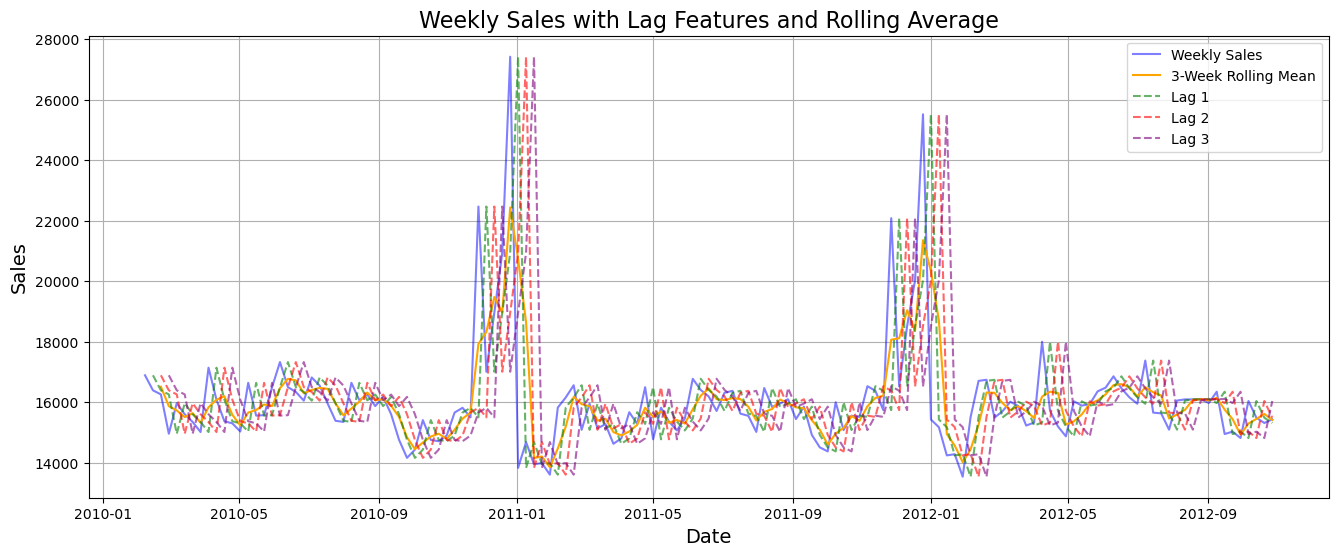

In [8]:
import matplotlib.pyplot as plt

# Creating a plot
plt.figure(figsize=(16, 6))

# Plotting Weekly Sales
plt.plot(df_week['Weekly_Sales'], label='Weekly Sales', color='blue', alpha=0.5)

# Plotting 3-Week Rolling Mean
plt.plot(df_week['Weekly_Sales_Rolling_Mean'], label='3-Week Rolling Mean', color='orange')

# Plotting Lag Features
plt.plot(df_week['Weekly_Sales_Lag_1'], label='Lag 1', linestyle='--', color='green', alpha=0.6)
plt.plot(df_week['Weekly_Sales_Lag_2'], label='Lag 2', linestyle='--', color='red', alpha=0.6)
plt.plot(df_week['Weekly_Sales_Lag_3'], label='Lag 3', linestyle='--', color='purple', alpha=0.6)

# Adding a title and labels
plt.title('Weekly Sales with Lag Features and Rolling Average', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.legend()
plt.grid()

plt.show()

In [9]:
# Resampling to a monthly frequency
df_month = df_prepro.resample('MS').mean()

# Calculating the 2-week rolling mean and standard deviation
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()

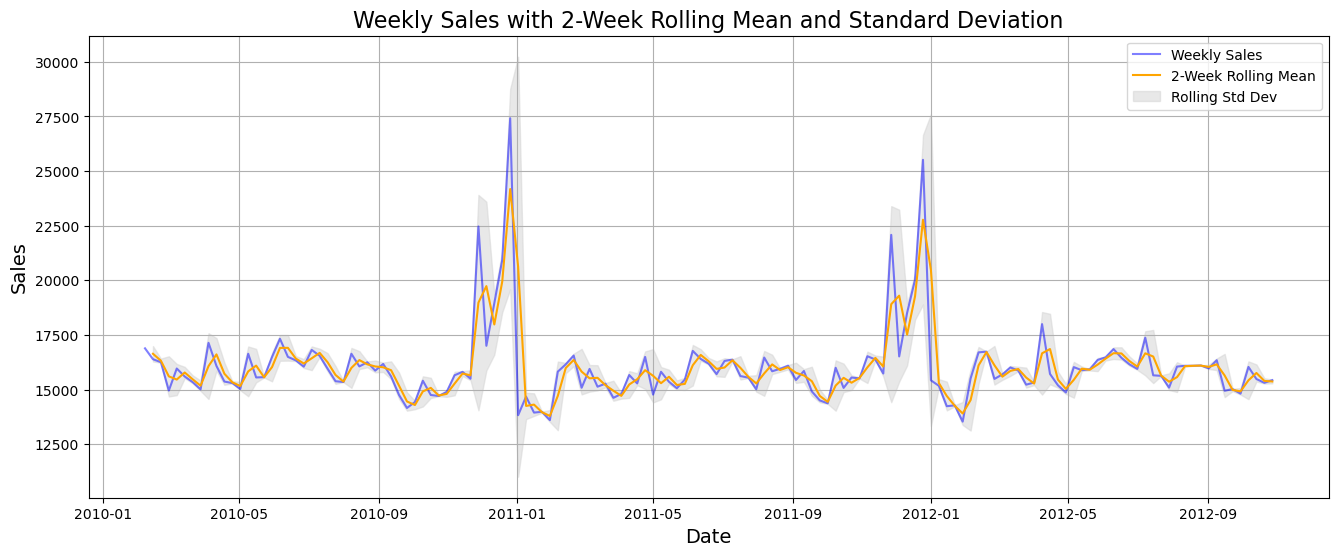

In [10]:
# Creating a plot
plt.figure(figsize=(16, 6))

# Plotting Weekly Sales
plt.plot(df_week['Weekly_Sales'], label='Weekly Sales', color='blue', alpha=0.5)

# Plotting Rolling Mean
plt.plot(roll_mean, label='2-Week Rolling Mean', color='orange')

# Plotting Rolling Std
plt.fill_between(roll_std.index, roll_mean - roll_std, roll_mean + roll_std, color='lightgrey', alpha=0.5, label='Rolling Std Dev')

# Adding a title and labels
plt.title('Weekly Sales with 2-Week Rolling Mean and Standard Deviation', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.legend()
plt.grid()

plt.show()

In [11]:
# ADF test
adf_result = adfuller(df_week['Weekly_Sales'])

# ADF results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -5.927107223737566
p-value: 2.4290492082043256e-07


**Results of the ADF Test and Interpretation :** <br>
**ADF Statistic:** -5.927 <br>
**p-value:** 2.43e-07 <br>

**Interpretation** <br> 
**ADF Statistic:** <br>
The negative ADF value (-5.927) indicates a **strong rejection of the null hypothesis.** In time series analysis, the null hypothesis of the ADF test states that the data has a unit root (meaning the time series is non-stationary). **The more negative the ADF value, the more likely the data is stationary.** <br>

**p-value:** <br>
The p-value, which is much lower than the commonly used significance level (e.g., 0.05), reinforces the rejection of the null hypothesis. In this case, a p-value of 2.43e-07 is well below 0.05, indicating that **the time series is stationary.** <br>

**Conclusion** <br>
The time series for Weekly_Sales is **stationary.** <br>
The results with Lag Features and Rolling Averages are **accepted and will be applied.**

### **Differencing**

In [9]:
# ADF test on df_week['Weekly_Sales'] after Lag and Rolling Averages
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_week['Weekly_Sales'].dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# perform differencing
df_week['Weekly_Sales_Diff'] = df_week['Weekly_Sales'].diff().dropna()
adf_result_diff = adfuller(df_week['Weekly_Sales_Diff'].dropna())
print(f'ADF Statistic (Differenced): {adf_result_diff[0]}')
print(f'p-value (Differenced): {adf_result_diff[1]}')

ADF Statistic: -5.927107223737566
p-value: 2.4290492082043256e-07
ADF Statistic (Differenced): -6.6748836036985555
p-value (Differenced): 4.491229681533421e-09


**Conclusion** <br>
The results with Lag Features and Rolling Averages are **accepted and will be applied.** <br>
The results with Differencing are **accepted and will be applied**

## **XGBoost Model**

In [10]:
# Creating a differencing column as a new target.
df_week['Weekly_Sales_Diff'] = df_week['Weekly_Sales'].diff().dropna()

# Drop missing values after differencing process
df_week = df_week.dropna()

# Splitting the data into training and testing sets
train_data, test_data = train_test_split(df_week, test_size=0.3, shuffle=False)

# Target using the differencing column
target = "Weekly_Sales_Diff"
features_models = df_week.columns[df_week.columns != target]  # Semua kolom kecuali target

X_train = train_data[features_models]
X_test = test_data[features_models]
y_train = train_data[target]
y_test = test_data[target]

# Import XGBoost
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Defining the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# Training model
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# The 'IsHoliday' column as weights, with 5 for holidays and 1 for regular days
weights = X_test['IsHoliday'].apply(lambda x: 5 if x == 1 else 1)

# WMAE Function
def wmae(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

# WMAE Function
wmae_value = wmae(y_test, y_pred, weights)
print(f'Weighted Mean Absolute Error (WMAE): {wmae_value}')

Mean Absolute Error (MAE): 233.23767651206077
Weighted Mean Absolute Error (WMAE): 211.75770797883993


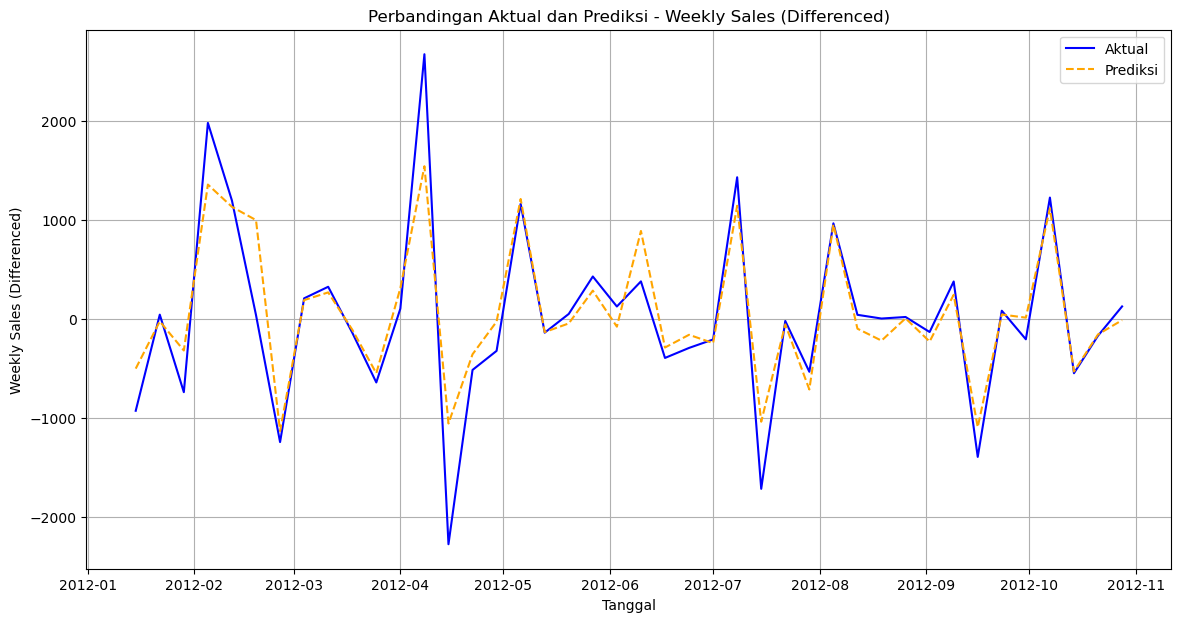

In [11]:
import matplotlib.pyplot as plt

# Adding predictions to the test dataframe
test_data['Predicted'] = y_pred 

# Creating a plot
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data['Weekly_Sales_Diff'], label='Aktual', color='blue')
plt.plot(test_data.index, test_data['Predicted'], label='Prediksi', color='orange', linestyle='--')
plt.title('Perbandingan Aktual dan Prediksi - Weekly Sales (Differenced)')
plt.xlabel('Tanggal')
plt.ylabel('Weekly Sales (Differenced)')
plt.legend()
plt.grid()
plt.show()

**Kesimpulan** <br>
* The results with the XGBoost Model are **accepted and will be applied** <br>
* A lower WMAE compared to MAE indicates that the model places more weight on errors that are more significant, such as on days or products that have a greater impact on the business, which aligns with the goal of maximizing accuracy on specific days or products.

## **SARIMA Model**

Mean Absolute Error (MAE) SARIMA: 1108.159175094281


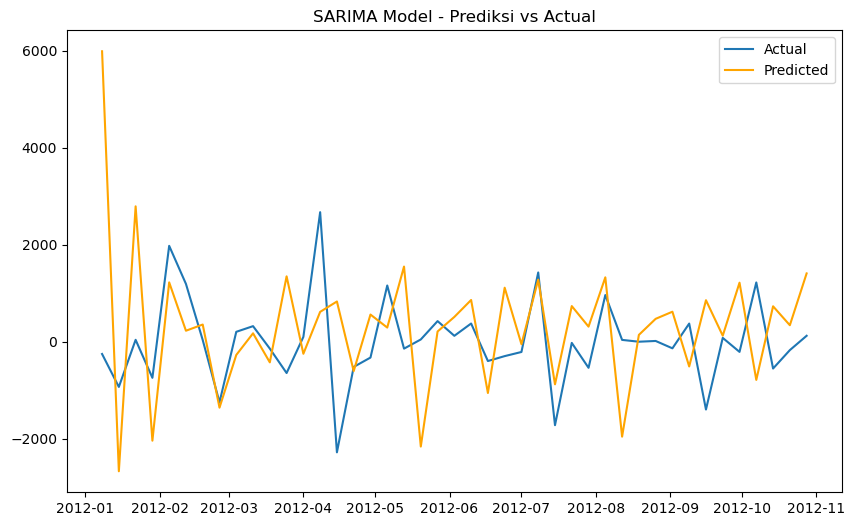

In [10]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

# Use only the differencing target column for SARIMA
sales_diff = df_week['Weekly_Sales_Diff'].dropna()

# Split the data into training and testing sets (based on time)
train_size = int(len(sales_diff) * 0.7)
train, test = sales_diff[:train_size], sales_diff[train_size:]

# Determine the SARIMA parameters (p, d, q) dan (P, D, Q, m)
# (p,d,q) for autoregression, differencing, dan moving average
# (P,D,Q,m) for seasonal component
sarima_model = sm.tsa.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))

# Fit model
sarima_result = sarima_model.fit(disp=False)

# Prediction
y_pred_sarima = sarima_result.forecast(steps=len(test))

# Calculating Mean Absolute Error (MAE) for SARIMA
mae_sarima = mean_absolute_error(test, y_pred_sarima)
print(f'Mean Absolute Error (MAE) SARIMA: {mae_sarima}')

# Plotting the predicted results vs. actual results
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, y_pred_sarima, label='Predicted', color='orange')
plt.title('SARIMA Model - Prediksi vs Actual')
plt.legend()
plt.show()

Weighted Mean Absolute Error (WMAE) SARIMA: 1079.3862432979824


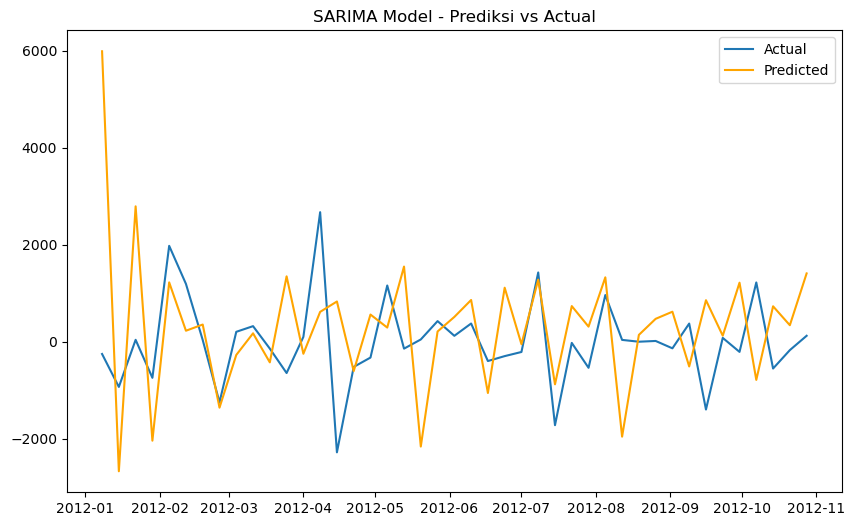

In [11]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

# Use only the differencing target column for SARIMA
sales_diff = df_week['Weekly_Sales_Diff'].dropna()

# Split the data into training and testing sets (based on time)
train_size = int(len(sales_diff) * 0.7)
train, test = sales_diff[:train_size], sales_diff[train_size:]

# SARIMA model (p, d, q) and (P, D, Q, m) for seasonal data
sarima_model = sm.tsa.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))

# Fit model
sarima_result = sarima_model.fit(disp=False)

# Prediction
y_pred_sarima = sarima_result.forecast(steps=len(test))

# The 'IsHoliday' column as weights, with 5 for holidays and 1 for regular days
weights = df_week.loc[test.index, 'IsHoliday'].apply(lambda x: 5 if x == 1 else 1)

# WMAE Function
def wmae(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

# WMAE values for SARIMA
wmae_sarima = wmae(test, y_pred_sarima, weights)
print(f'Weighted Mean Absolute Error (WMAE) SARIMA: {wmae_sarima}')

# Plotting the predicted results vs. actual results
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, y_pred_sarima, label='Predicted', color='orange')
plt.title('SARIMA Model - Prediksi vs Actual')
plt.legend()
plt.show()

**Conclusion** <br>
The results with SARIMA are **rejected and will not be applied.**

## **Exponential Smoothing**

Mean Absolute Error (MAE): 659.5386140815527
Weighted Mean Absolute Error (WMAE): 647.1536215835416


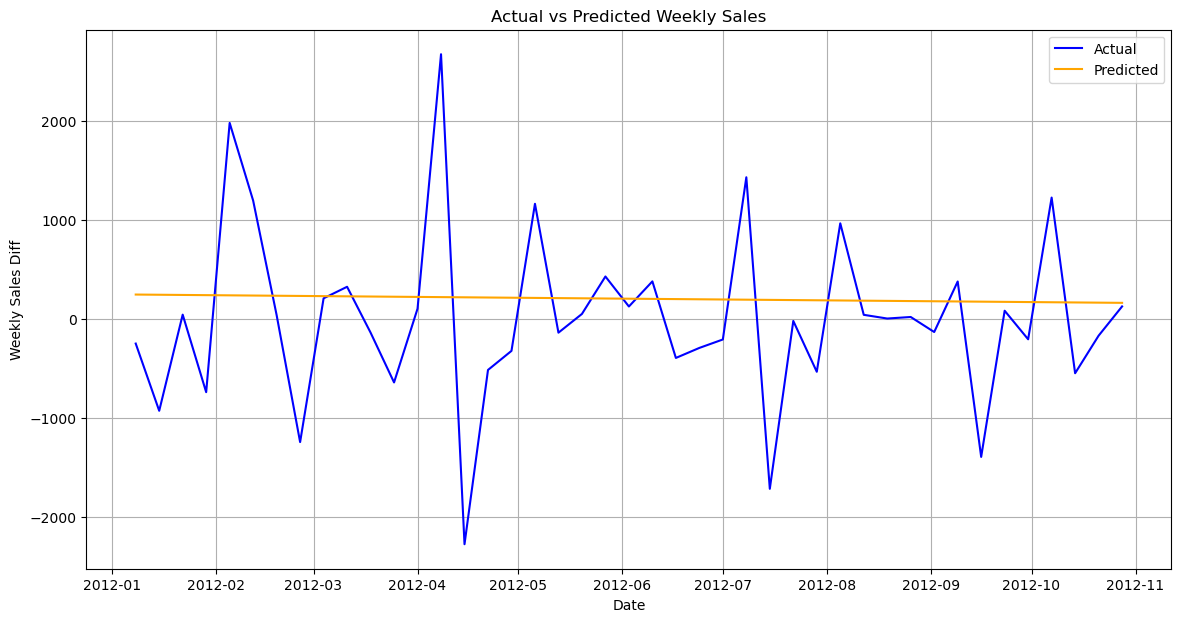

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Ensure there are no NaN values in the 'Weekly_Sales_Diff' column
df_week = df_week.dropna(subset=['Weekly_Sales_Diff'])

# Split the data into training and testing sets
train_data, test_data = train_test_split(df_week, test_size=0.3, shuffle=False)

# Target and features
target = "Weekly_Sales_Diff"
features_models = df_week.columns[df_week.columns != target]

# Exponential Smoothing Model 
model = ExponentialSmoothing(train_data[target], trend='add', seasonal=None)
model_fit = model.fit()

# Prediction
y_pred = model_fit.forecast(len(test_data))

# Calculating Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data[target], y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculating WMAE
weights = test_data['IsHoliday'].apply(lambda x: 5 if x == 1 else 1)
def wmae(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

wmae_value = wmae(test_data[target], y_pred, weights)
print(f'Weighted Mean Absolute Error (WMAE): {wmae_value}')

# Plotting the predicted results vs. actual results
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data[target], label='Actual', color='blue')
plt.plot(test_data.index, y_pred, label='Predicted', color='orange')
plt.title('Actual vs Predicted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales Diff')
plt.legend()
plt.grid()
plt.show()

**Conclusion** <br>
The results with Exponential Smoothing are **rejected and will not be applied**